In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
#hide
from fastbook import *
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

# Tabular Modeling Deep Dive

# 表格建模深潜[机器翻译]

Tabular modeling takes data in the form of a table (like a spreadsheet or CSV). The objective is to predict the value in one column based on the values in the other columns. In this chapter we will not only look at deep learning but also more general machine learning techniques like random forests, as they can give better results depending on your problem.


表格建模采用表格形式的数据 (如电子表格或CSV)。目标是基于一列中其他列中的值来预测一列中的值。在本章中，我们不仅将关注深度学习，还将关注更通用的机器学习技术，如随机森林，因为它们可以根据您的问题给出更好的结果。[机器翻译]

We will look at how we should preprocess and clean the data as well as how to interpret the result of our models after training, but first, we will see how we can feed columns that contain categories into a model that expects numbers by using embeddings.

我们将研究如何预处理和清理数据，以及如何在训练后解释模型的结果，但是首先，我们将看到如何通过使用嵌入将包含类别的列馈送到期望数字的模型中。[机器翻译]

## Categorical Embeddings

# # 分类嵌入[机器翻译]

In tabular data some columns may contain numerical data, like "age," while others contain string values, like "sex." The numerical data can be directly fed to the model (with some optional preprocessing), but the other columns need to be converted to numbers. Since the values in those correspond to different categories, we often call this type of variables *categorical variables*. The first type are called *continuous variables*.

在表格数据中，一些列可能包含数字数据，如 “age”，而其他列包含字符串值，如 “sex”。数值数据可以直接馈送到模型 (带有一些可选的预处理)，但其他列需要转换为数字。由于这些变量中的值对应于不同的类别，我们通常将这种类型的变量称为 * 分类变量 *。第一种类型称为 * 连续变量 *。[机器翻译]

> jargon: Continuous and Categorical Variables: Continuous variables are numerical data, such as "age," that can be directly fed to the model, since you can add and multiply them directly. Categorical variables contain a number of discrete levels, such as "movie ID," for which addition and multiplication don't have meaning (even if they're stored as numbers).

> 行话: 连续变量和分类变量: 连续变量是数值数据，如 “年龄”，可以直接输入模型，因为您可以直接添加和乘以它们。分类变量包含许多离散级别，如 “电影ID”，加法和乘法没有意义 (即使它们存储为数字)。[机器翻译]

At the end of 2015, the [Rossmann sales competition](https://www.kaggle.com/c/rossmann-store-sales) ran on Kaggle. Competitors were given a wide range of information about various stores in Germany, and were tasked with trying to predict sales on a number of days. The goal was to help the company to manage stock properly and be able to satisfy demand without holding unnecessary inventory. The official training set provided a lot of information about the stores. It was also permitted for competitors to use additional data, as long as that data was made public and available to all participants.


2015年底，【罗斯曼销售大赛】 ( https://www.kaggle.com/c/rossmann-store-sales ) 在卡格尔身上跑。竞争对手获得了关于德国各种商店的广泛信息，并被要求在几天内尝试预测销售额。目标是帮助公司正确管理库存，能够满足需求，而不持有不必要的库存。官方培训集提供了很多关于商店的信息。还允许竞争对手使用额外的数据，只要这些数据被公开并提供给所有参与者。[机器翻译]

One of the gold medalists used deep learning, in one of the earliest known examples of a state-of-the-art deep learning tabular model. Their method involved far less feature engineering, based on domain knowledge, than those of the other gold medalists. The paper, ["Entity Embeddings of Categorical Variables"](https://arxiv.org/abs/1604.06737) describes their approach. In an online-only chapter on the [book's website](https://book.fast.ai/) we show how to replicate it from scratch and attain the same accuracy shown in the paper. In the abstract of the paper the authors (Cheng Guo and Felix Bekhahn) say:

其中一个金牌得主使用了深度学习，这是最先进的深度学习表格模型的最早已知例子之一。他们的方法涉及的基于领域知识的特征工程远远少于其他金牌得主。论文，[“分类变量的实体嵌入”] ( https://arxiv.org/abs/1604.06737 ) 描述了他们的方法。在 [图书网站] 上的一个只有在线的章节中 ( https://book.fast.ai/ ) 我们展示了如何从头开始复制它，并达到论文中所示的相同精度。在论文摘要中，作者 (Cheng Guo和Felix Bekhahn) 说:[机器翻译]

> : Entity embedding not only reduces memory usage and speeds up neural networks compared with one-hot encoding, but more importantly by mapping similar values close to each other in the embedding space it reveals the intrinsic properties of the categorical variables... [It] is especially useful for datasets with lots of high cardinality features, where other methods tend to overfit... As entity embedding defines a distance measure for categorical variables it can be used for visualizing categorical data and for data clustering.

>: 与one-hot编码相比，实体嵌入不仅可以减少内存使用并加快神经网络速度，但更重要的是，通过在嵌入空间中相互接近地映射相似的值，它揭示了分类变量的内在属性.[它] 对于具有许多高基数特征的数据集特别有用，在这些数据集中，其他方法往往会过度匹配.由于实体嵌入定义了分类变量的距离度量，它可用于可视化分类数据和数据聚类。[机器翻译]

We have already noticed all of these points when we built our collaborative filtering model. We can clearly see that these insights go far beyond just collaborative filtering, however.


当我们构建协作过滤模型时，我们已经注意到了所有这些点。然而，我们可以清楚地看到，这些见解远远不仅仅是协作过滤。[机器翻译]

The paper also points out that (as we discussed in the last chapter) an embedding layer is exactly equivalent to placing an ordinary linear layer after every one-hot-encoded input layer. The authors used the diagram in <<entity_emb>> to show this equivalence. Note that "dense layer" is a term with the same meaning as "linear layer," and the one-hot encoding layers represent inputs.

本文还指出 (正如我们在最后一章中讨论的) 嵌入层正好相当于在每个热编码输入层之后放置一个普通的线性层。作者使用 <<entity_emb>> 中的图表来显示这种等价性。请注意，“致密层” 是与 “线性层” 具有相同含义的术语，并且单热编码层表示输入。[机器翻译]

<img alt="Entity embeddings in a neural network" width="600" caption="Entity embeddings in a neural network (courtesy of Cheng Guo and Felix Berkhahn)" id="entity_emb" src="images/att_00018.png">

<Img alt = "神经网络中的实体嵌入" width = "600" caption = "神经网络中的实体嵌入 (由Cheng Guo和Felix Berkhahn提供)" id = "entity_emb" src = "images/att_00018.png">[机器翻译]

The insight is important because we already know how to train linear layers, so this shows that from the point of view of the architecture and our training algorithm the embedding layer is just another layer. We also saw this in practice in the last chapter, when we built a collaborative filtering neural network that looks exactly like this diagram.


洞察很重要，因为我们已经知道如何训练线性层，所以这表明，从架构和我们的训练算法的角度来看，嵌入层只是另一个层。我们在最后一章的实践中也看到了这一点，当时我们构建了一个与本图完全相似的协同过滤神经网络。[机器翻译]

Where we analyzed the embedding weights for movie reviews, the authors of the entity embeddings paper analyzed the embedding weights for their sales prediction model. What they found was quite amazing, and illustrates their second key insight. This is that the embedding transforms the categorical variables into inputs that are both continuous and meaningful.


我们分析了电影评论的嵌入权重，实体嵌入论文的作者分析了他们销售预测模型的嵌入权重。他们的发现非常惊人，说明了他们的第二个关键见解。这就是嵌入将分类变量转换为连续且有意义的输入。[机器翻译]

The images in <<state_emb>> illustrate these ideas. They are based on the approaches used in the paper, along with some analysis we have added.

<<State_emb>> 中的图像说明了这些想法。它们基于论文中使用的方法，以及我们添加的一些分析。[机器翻译]

<img alt="State embeddings and map" width="800" caption="State embeddings and map (courtesy of Cheng Guo and Felix Berkhahn)" id="state_emb" src="images/att_00015.png">

<Img alt = "状态嵌入和地图" width = "800" caption = "状态嵌入和地图 (由Cheng Guo和Felix Berkhahn提供)" id = "state_emb" src = "images/att_00015.png">[机器翻译]

On the left is a plot of the embedding matrix for the possible values of the `State` category. For a categorical variable we call the possible values of the variable its "levels" (or "categories" or "classes"), so here one level is "Berlin," another is "Hamburg," etc. On the right is a map of Germany. The actual physical locations of the German states were not part of the provided data, yet the model itself learned where they must be, based only on the behavior of store sales!


左边是 “状态” 类别的可能值的嵌入矩阵图。对于分类变量，我们将变量的可能值称为 “级别” (或 “类别” 或 “类”)，所以这里有一个级别是 “柏林”，另一个是 “汉堡” 等。右边是德国的地图。德国各州的实际物理位置不是所提供数据的一部分，但是模型本身仅仅根据商店销售的行为就知道了它们必须在哪里![机器翻译]

Do you remember how we talked about *distance* between embeddings? The authors of the paper plotted the distance between store embeddings against the actual geographic distance between the stores (see <<store_emb>>). They found that they matched very closely!

你还记得我们如何谈论嵌入之间的距离吗？该论文的作者绘制了商店嵌入之间的距离与商店之间的实际地理距离 (参见 <<store_emb>>)。他们发现他们非常匹配![机器翻译]

<img alt="Store distances" width="600" caption="Store distances (courtesy of Cheng Guo and Felix Berkhahn)" id="store_emb" src="images/att_00016.png">

<Img alt = "商店距离" width = "600" caption = "商店距离 (由Cheng Guo和Felix Berkhahn提供)" id = "store_emb" src = "images/att_00016.png">[机器翻译]

We've even tried plotting the embeddings for days of the week and months of the year, and found that days and months that are near each other on the calendar ended up close as embeddings too, as shown in <<date_emb>>.

我们甚至尝试绘制一周中的几天和一年中的几个月的嵌入图，发现日历上彼此靠近的几天和几个月最终也成为嵌入图，如 <<date_emb>> 所示。[机器翻译]

<img alt="Date embeddings" width="900" caption="Date embeddings" id="date_emb" src="images/att_00017.png">

<Img alt = "日期嵌入" width = "900" caption = "Date嵌入" id = "date_emb" src = "images/att_00017.png">[机器翻译]

What stands out in these two examples is that we provide the model fundamentally categorical data about discrete entities (e.g., German states or days of the week), and then the model learns an embedding for these entities that defines a continuous notion of distance between them. Because the embedding distance was learned based on real patterns in the data, that distance tends to match up with our intuitions.


这两个例子中突出的是，我们从根本上提供了关于离散实体的模型分类数据 (e.g.，德国国家或一周中的几天)，然后模型学习这些实体的嵌入，定义它们之间距离的连续概念。因为嵌入距离是基于数据中的真实模式学习的，所以该距离往往与我们的直觉相匹配。[机器翻译]

In addition, it is valuable in its own right that embeddings are continuous, because models are better at understanding continuous variables. This is unsurprising considering models are built of many continuous parameter weights and continuous activation values, which are updated via gradient descent (a learning algorithm for finding the minimums of continuous functions).


此外，嵌入是连续的，这本身是有价值的，因为模型更善于理解连续变量。这并不令人惊讶，考虑到模型是由许多连续参数权重和连续激活值构建的，它们通过梯度下降 (用于寻找连续函数最小值的学习算法) 进行更新。[机器翻译]

Another benefit is that we can combine our continuous embedding values with truly continuous input data in a straightforward manner: we just concatenate the variables, and feed the concatenation into our first dense layer. In other words, the raw categorical data is transformed by an embedding layer before it interacts with the raw continuous input data. This is how fastai and Guo and Berkham handle tabular models containing continuous and categorical variables.


另一个好处是，我们可以以简单的方式将我们的连续嵌入值与真正连续的输入数据结合起来: 我们只是连接变量，并将连接馈送到我们的第一个密集层中。换句话说，原始分类数据在与原始连续输入数据交互之前由嵌入层进行转换。这就是fastai、Guo和Berkham如何处理包含连续和分类变量的表格模型。[机器翻译]

An example using this concatenation approach is how Google does it recommendations on Google Play, as explained in the paper ["Wide & Deep Learning for Recommender Systems"](https://arxiv.org/abs/1606.07792). <<google_recsys>> illustrates.

使用这种串联方法的一个例子是Google如何对Google Play进行推荐，如 [“推荐系统的广泛和深度学习”] ( https://arxiv.org/abs/1606.07792 )。<<Google_recsys>> 说明了这一点。[机器翻译]

<img alt="The Google Play recommendation system" width="800" caption="The Google Play recommendation system" id="google_recsys" src="images/att_00019.png">

<Img alt = "Google Play推荐系统" width = "800" caption = "Google Play推荐系统" id = "google_recsys" src = "images/att_00019.png">[机器翻译]

Interestingly, the Google team actually combined both approaches we saw in the previous chapter: the dot product (which they call *cross product*) and neural network approaches.


有趣的是，谷歌团队实际上结合了我们在前一章中看到的两种方法: 点积 (他们称之为 * 交叉积 *) 和神经网络方法。[机器翻译]

Let's pause for a moment. So far, the solution to all of our modeling problems has been: *train a deep learning model*. And indeed, that is a pretty good rule of thumb for complex unstructured data like images, sounds, natural language text, and so forth. Deep learning also works very well for collaborative filtering. But it is not always the best starting point for analyzing tabular data.

让我们暂停一下。到目前为止，我们所有建模问题的解决方案是: * 训练深度学习模型 *。事实上，对于复杂的非结构化数据，如图像、声音、自然语言文本等，这是一个非常好的经验法则。深度学习对于协作过滤也非常有效。但它并不总是分析表格数据的最佳起点。[机器翻译]

## Beyond Deep Learning

# # 超越深度学习[机器翻译]

Most machine learning courses will throw dozens of different algorithms at you, with a brief technical description of the math behind them and maybe a toy example. You're left confused by the enormous range of techniques shown and have little practical understanding of how to apply them.


大多数机器学习课程会向你扔几十种不同的算法，并对它们背后的数学进行简要的技术描述，也许还有一个玩具例子。你被展示的各种技术弄糊涂了，对如何应用它们几乎没有实际的理解。[机器翻译]

The good news is that modern machine learning can be distilled down to a couple of key techniques that are widely applicable. Recent studies have shown that the vast majority of datasets can be best modeled with just two methods:


好消息是，现代机器学习可以归结为一些广泛适用的关键技术。最近的研究表明，绝大多数数据集可以用两种方法进行最佳建模:[机器翻译]

1. Ensembles of decision trees (i.e., random forests and gradient boosting machines), mainly for structured data (such as you might find in a database table at most companies)
1. Multilayered neural networks learned with SGD (i.e., shallow and/or deep learning), mainly for unstructured data (such as audio, images, and natural language)

1.决策树的集合 (即随机森林和梯度提升机器)，主要用于结构化数据 (例如您可能在大多数公司的数据库表中找到)
1.使用SGD学习的多层神经网络 (即，浅层和/或深度学习)，主要用于非结构化数据 (如音频、图像和自然语言)[机器翻译]

Although deep learning is nearly always clearly superior for unstructured data, these two approaches tend to give quite similar results for many kinds of structured data. But ensembles of decision trees tend to train faster, are often easier to interpret, do not require special GPU hardware for inference at scale, and often require less hyperparameter tuning. They have also been popular for quite a lot longer than deep learning, so there is a more mature ecosystem of tooling and documentation around them.


尽管深度学习对于非结构化数据几乎总是明显优越，但这两种方法倾向于对多种结构化数据给出非常相似的结果。但是决策树的集合往往训练得更快，通常更容易解释，不需要特殊的GPU硬件来大规模推理，并且通常需要更少的超参数调整。它们也比深度学习流行了很长时间，所以它们周围有一个更成熟的工具和文档生态系统。[机器翻译]

Most importantly, the critical step of interpreting a model of tabular data is significantly easier for decision tree ensembles. There are tools and methods for answering the pertinent questions, like: Which columns in the dataset were the most important for your predictions? How are they related to the dependent variable? How do they interact with each other? And which particular features were most important for some particular observation?


最重要的是，对于决策树集合来说，解释表格数据模型的关键步骤要容易得多。有一些工具和方法可以回答相关的问题，比如: 数据集中的哪些列对你的预测最重要？它们如何与因变量相关？他们如何相互作用？对于某些特定的观察，哪些特定的特征是最重要的？[机器翻译]

Therefore, ensembles of decision trees are our first approach for analyzing a new tabular dataset.


因此，决策树集合是我们分析新表格数据集的第一种方法。[机器翻译]

The exception to this guideline is when the dataset meets one of these conditions:


此指南的例外情况是数据集满足以下条件之一:[机器翻译]

- There are some high-cardinality categorical variables that are very important ("cardinality" refers to the number of discrete levels representing categories, so a high-cardinality categorical variable is something like a zip code, which can take on thousands of possible levels).
- There are some columns that contain data that would be best understood with a neural network, such as plain text data.


-有一些非常重要的高基数分类变量 (“基数” 是指代表类别的离散级别的数量，因此，高基数分类变量类似于邮政编码，可以具有数千个可能的级别)。
-有些列包含使用神经网络最好理解的数据，例如纯文本数据。[机器翻译]

In practice, when we deal with datasets that meet these exceptional conditions, we always try both decision tree ensembles and deep learning to see which works best. It is likely that deep learning will be a useful approach in our example of collaborative filtering, as we have at least two high-cardinality categorical variables: the users and the movies. But in practice things tend to be less cut-and-dried, and there will often be a mixture of high- and low-cardinality categorical variables and continuous variables.


在实践中，当我们处理满足这些特殊条件的数据集时，我们总是尝试决策树集合和深度学习，看看哪个效果最好。在我们的协作过滤示例中，深度学习很可能是一种有用的方法，因为我们至少有两个高基数的分类变量: 用户和电影。但是在实践中，事情往往不那么一成不变，而且经常会有高低基数分类变量和连续变量的混合。[机器翻译]

Either way, it's clear that we are going to need to add decision tree ensembles to our modeling toolbox!

不管怎样，很明显，我们需要将决策树集合添加到我们的建模工具箱中![机器翻译]

Up to now we've used PyTorch and fastai for pretty much all of our heavy lifting. But these libraries are mainly designed for algorithms that do lots of matrix multiplication and derivatives (that is, stuff like deep learning!). Decision trees don't depend on these operations at all, so PyTorch isn't much use.


到目前为止，我们已经使用PyTorch和fastai来完成几乎所有的繁重工作。但是这些库主要是为做大量矩阵乘法和导数的算法而设计的 (也就是说，像深度学习这样的东西!)。决策树完全不依赖于这些操作，所以PyTorch没有多大用处。[机器翻译]

Instead, we will be largely relying on a library called scikit-learn (also known as `sklearn`). Scikit-learn is a popular library for creating machine learning models, using approaches that are not covered by deep learning. In addition, we'll need to do some tabular data processing and querying, so we'll want to use the Pandas library. Finally, we'll also need NumPy, since that's the main numeric programming library that both sklearn and Pandas rely on.


相反，我们将在很大程度上依赖一个名为scikit-learn的库 (也称为 “sklearn”)。Scikit-learn是一个流行的库，用于使用深度学习未涵盖的方法创建机器学习模型。此外，我们需要做一些表格数据处理和查询，所以我们想使用Pandas库。最后，我们还需要NumPy，因为这是sklearn和Pandas都依赖的主要数值编程库。[机器翻译]

We don't have time to do a deep dive into all these libraries in this book, so we'll just be touching on some of the main parts of each. For a far more in depth discussion, we strongly suggest Wes McKinney's [Python for Data Analysis](http://shop.oreilly.com/product/0636920023784.do) (O'Reilly). Wes is the creator of Pandas, so you can be sure that the information is accurate!


我们没有时间深入阅读本书中的所有这些图书馆，所以我们将只讨论每个图书馆的一些主要部分。为了进行更深入的讨论，我们强烈建议Wes McKinney的 [Python For Data Analysis]( http://shop.oreilly.com/product/0636920023784.do ) (奥赖利)。韦斯是熊猫的创造者，所以你可以肯定信息是准确的![机器翻译]

First, let's gather the data we will use.

首先，让我们收集我们将使用的数据。[机器翻译]

## The Dataset

# # 数据集[机器翻译]

The dataset we use in this chapter is from the Blue Book for Bulldozers Kaggle competition, which has the following description: "The goal of the contest is to predict the sale price of a particular piece of heavy equipment at auction based on its usage, equipment type, and configuration.  The data is sourced from auction result postings and includes information on usage and equipment configurations."


我们在本章中使用的数据集来自推土机Kaggle竞赛蓝皮书，其中有以下描述: “比赛的目标是根据某件重型设备的用途、设备类型和配置，预测其拍卖价格。数据来自拍卖结果发布，包括使用和设备配置信息。"[机器翻译]

This is a very common type of dataset and prediction problem, similar to what you may see in your project or workplace. The dataset is available for download on Kaggle, a website that hosts data science competitions.

这是一种非常常见的数据集和预测问题，类似于您在项目或工作场所中看到的问题。数据集可在Kaggle网站上下载，该网站主办数据科学竞赛。[机器翻译]

### Kaggle Competitions

# Kaggle比赛[机器翻译]

Kaggle is an awesome resource for aspiring data scientists or anyone looking to improve their machine learning skills.  There is nothing like getting hands-on practice and receiving real-time feedback to help you improve your skills.


Kaggle是有抱负的数据科学家或任何希望提高机器学习技能的人的绝佳资源。没有什么比动手练习和接收实时反馈更能帮助你提高技能了。[机器翻译]

Kaggle provides:


Kaggle提供:[机器翻译]

- Interesting datasets
- Feedback on how you're doing
- A leaderboard to see what's good, what's possible, and what's state-of-the-art
- Blog posts by winning contestants sharing useful tips and techniques


-有趣的数据集
-关于你如何做的反馈
-一个排行榜，看看什么是好的，什么是可能的，什么是最先进的
-通过获奖选手分享有用的提示和技巧的博客帖子[机器翻译]

Until now all our datasets have been available to download through fastai's integrated dataset system. However, the dataset we will be using in this chapter is only available from Kaggle. Therefore, you will need to register on the site, then go to the [page for the competition](https://www.kaggle.com/c/bluebook-for-bulldozers). On that page click "Rules," then "I Understand and Accept." (Although the competition has finished, and you will not be entering it, you still have to agree to the rules to be allowed to download the data.)


到目前为止，我们所有的数据集都可以通过fastai的集成数据集系统下载。然而，我们将在本章中使用的数据集只能从Kaggle获得。因此，您需要在网站上注册，然后转到比赛的 [页面] ( https://www.kaggle.com/c/bluebook-for-bulldozers )。在该页面上单击 “规则”，然后 “我理解并接受”。”(虽然比赛已经结束，你也不会参加，但你仍然必须同意允许下载数据的规则。)[机器翻译]

The easiest way to download Kaggle datasets is to use the Kaggle API. You can install this using `pip` by running this in a notebook cell:


下载Kaggle数据集的最简单方法是使用Kaggle API。您可以通过在笔记本单元格中运行 “pipe” 来使用 “pipe” 安装此设备:[机器翻译]

    !pip install kaggle


!Pip安装kaggle[机器翻译]

You need an API key to use the Kaggle API; to get one, click on your profile picture on the Kaggle website, and choose My Account, then click Create New API Token. This will save a file called *kaggle.json* to your PC. You need to copy this key on your GPU server. To do so, open the file you downloaded, copy the contents, and paste them in the following cell in the notebook associated with this chapter (e.g., `creds = '{"username":"xxx","key":"xxx"}'`):

您需要一个应用编程接口密钥来使用Kaggle应用编程接口; 要获得一个，请在Kaggle网站上单击您的个人资料图片，然后选择我的帐户，然后单击创建新的应用编程接口令牌。这将保存一个名为 * kaggle.json * 的文件到您的PC。您需要在GPU服务器上复制此密钥。为此，请打开您下载的文件，复制内容，并将其粘贴到与本章相关联的笔记本的以下单元格中 (e g.，'Creds ='{"username":"xxx"，"key":"xxx"}''):[机器翻译]

In [ ]:
creds = ''

Then execute this cell (this only needs to be run once):

然后执行这个单元格 (这只需要运行一次):[机器翻译]

In [ ]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write(creds)
    cred_path.chmod(0o600)

Now you can download datasets from Kaggle! Pick a path to download the dataset to:

现在您可以从Kaggle下载数据集!选择将数据集下载到的路径:[机器翻译]

In [ ]:
path = URLs.path('bluebook')
path

Path('/home/sgugger/.fastai/archive/bluebook')

In [ ]:
#hide
Path.BASE_PATH = path

And use the Kaggle API to download the dataset to that path, and extract it:

并使用Kaggle API将数据集下载到该路径，然后提取它:[机器翻译]

In [ ]:
if not path.exists():
    path.mkdir()
    api.competition_download_cli('bluebook-for-bulldozers', path=path)
    file_extract(path/'bluebook-for-bulldozers.zip')

path.ls(file_type='text')

(#7) [Path('Valid.csv'),Path('Machine_Appendix.csv'),Path('ValidSolution.csv'),Path('TrainAndValid.csv'),Path('random_forest_benchmark_test.csv'),Path('Test.csv'),Path('median_benchmark.csv')]

Now that we have downloaded our dataset, let's take a look at it!

既然我们已经下载了数据集，让我们来看看它![机器翻译]

### Look at the Data

# 看数据[机器翻译]

Kaggle provides information about some of the fields of our dataset. The [Data](https://www.kaggle.com/c/bluebook-for-bulldozers/data) explains that the key fields in *train.csv* are:


Kaggle提供了有关我们数据集的一些字段的信息。【数据】 ( https://www.kaggle.com/c/bluebook-for-bulldozers/data ) 解释了 * train.csv * 中的关键字段是:[机器翻译]

- `SalesID`:: The unique identifier of the sale.
- `MachineID`:: The unique identifier of a machine.  A machine can be sold multiple times.
- `saleprice`:: What the machine sold for at auction (only provided in *train.csv*).
- `saledate`:: The date of the sale.


-'Salesid':: 销售的唯一标识符。
-'Machineid':: 机器的唯一标识符。一台机器可以多次销售。
-'Saleprice':: 机器在拍卖会上卖了什么 (仅在 * train.csv * 中提供)。
-'销售日期':: 销售日期。[机器翻译]

In any sort of data science work, it's important to *look at your data directly* to make sure you understand the format, how it's stored, what types of values it holds, etc. Even if you've read a description of the data, the actual data may not be what you expect. We'll start by reading the training set into a Pandas DataFrame. Generally it's a good idea to specify `low_memory=False` unless Pandas actually runs out of memory and returns an error. The `low_memory` parameter, which is `True` by default, tells Pandas to only look at a few rows of data at a time to figure out what type of data is in each column. This means that Pandas can actually end up using different data type for different rows, which generally leads to data processing errors or model training problems later.


在任何类型的数据科学工作中，重要的是 * 直接查看您的数据 * 以确保您理解格式、它是如何存储的、它包含什么类型的值，等。即使您已经阅读了数据的描述，实际数据也可能不是您所期望的。我们将从将训练集读入Pandas DataFrame开始。通常，指定 “low_memory = false” 是一个好主意，除非Pandas实际上耗尽了内存并返回错误。“Low _ memory” 参数 (默认为 “true”) 告诉熊猫一次只查看几行数据，以确定每列中的数据类型。这意味着Pandas实际上可以对不同的行使用不同的数据类型，这通常会导致数据处理错误或模型训练问题。[机器翻译]

Let's load our data and have a look at the columns:

让我们加载我们的数据，看看列:[机器翻译]

In [ ]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

In [ ]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

That's a lot of columns for us to look at! Try looking through the dataset to get a sense of what kind of information is in each one. We'll shortly see how to "zero in" on the most interesting bits.


我们可以看很多专栏!尝试查看数据集以了解每个数据集中的信息类型。我们很快就会看到如何在最有趣的位上 “归零”。[机器翻译]

At this point, a good next step is to handle *ordinal columns*. This refers to columns containing strings or similar, but where those strings have a natural ordering. For instance, here are the levels of `ProductSize`:

此时，一个很好的下一步是处理 * 序数列 *。这是指包含字符串或类似内容的列，但这些字符串具有自然顺序。例如，以下是 “productsize” 的级别:[机器翻译]

In [ ]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

We can tell Pandas about a suitable ordering of these levels like so:

我们可以告诉Pandas这些级别的合适顺序，如:[机器翻译]

In [ ]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'

In [ ]:
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

The most important data column is the dependent variable—that is, the one we want to predict. Recall that a model's metric is a function that reflects how good the predictions are. It's important to note what metric is being used for a project. Generally, selecting the metric is an important part of the project setup. In many cases, choosing a good metric will require more than just selecting a variable that already exists. It is more like a design process. You should think carefully about which metric, or set of metrics, actually measures the notion of model quality that matters to you. If no variable represents that metric, you should see if you can build the metric from the variables that are available.


最重要的数据列是因变量 -- 也就是我们要预测的那个。回想一下，模型的度量是反映预测效果的函数。重要的是要注意项目使用的是什么指标。通常，选择度量是项目设置的重要部分。在许多情况下，选择一个好的指标不仅仅需要选择一个已经存在的变量。它更像是一个设计过程。您应该仔细考虑哪个指标或一组指标实际上测量了对您重要的模型质量概念。如果没有变量表示该指标，您应该看看是否可以从可用的变量构建指标。[机器翻译]

However, in this case Kaggle tells us what metric to use: root mean squared log error (RMSLE) between the actual and predicted auction prices. We need do only a small amount of processing to use this: we take the log of the prices, so that `rmse` of that value will give us what we ultimately need:

然而，在这种情况下，Kaggle告诉我们使用什么度量: 实际和预测拍卖价格之间的均方根对数误差 (RMSLE)。我们只需要做少量的处理就可以使用它: 我们记录价格日志，这样该价值的 “rmse” 将为我们提供最终需要的东西:[机器翻译]

In [ ]:
dep_var = 'SalePrice'

In [ ]:
df[dep_var] = np.log(df[dep_var])

We are now ready to explore our first machine learning algorithm for tabular data: decision trees.

我们现在准备探索我们的第一个表格数据机器学习算法: 决策树。[机器翻译]

## Decision Trees

# # 决策树[机器翻译]

Decision tree ensembles, as the name suggests, rely on decision trees. So let's start there! A decision tree asks a series of binary (that is, yes or no) questions about the data. After each question the data at that part of the tree is split between a "yes" and a "no" branch, as shown in <<decision_tree>>. After one or more questions, either a prediction can be made on the basis of all previous answers or another question is required.

决策树集合，顾名思义，依赖于决策树。所以让我们从那里开始吧!决策树会询问一系列关于数据的二进制 (即是或否) 问题。在每个问题之后，树的该部分的数据被分成 “是” 和 “否” 分支，如 <<decision_tree>> 所示。在一个或多个问题之后，可以在所有先前答案的基础上进行预测，或者需要另一个问题。[机器翻译]

<img alt="An example of decision tree" width="600" caption="An example of decision tree" id="decision_tree" src="images/decision_tree.PNG">

<Img alt = "决策树示例" width = "600" caption = "决策树示例" id = "decision_tree" src = "images/decision_tree.PNG">[机器翻译]

This sequence of questions is now a procedure for taking any data item, whether an item from the training set or a new one, and assigning that item to a group. Namely, after asking and answering the questions, we can say the item belongs to the same group as all the other training data items that yielded the same set of answers to the questions. But what good is this? The goal of our model is to predict values for items, not to assign them into groups from the training dataset. The value is that we can now assign a prediction value for each of these groups—for regression, we take the target mean of the items in the group.


这个问题序列现在是一个过程，用于获取任何数据项，无论是训练集中的项目还是新的项目，并将该项目分配给一个组。也就是说，在提问和回答问题之后，我们可以说该项目与产生相同问题答案集的所有其他训练数据项属于同一组。但这有什么好处呢？我们模型的目标是预测项目的值，而不是将它们从训练数据集分配到组中。值是我们现在可以为这些组中的每一个分配一个预测值 -- 对于回归，我们取组中项目的目标平均值。[机器翻译]

Let's consider how we find the right questions to ask. Of course, we wouldn't want to have to create all these questions ourselves—that's what computers are for! The basic steps to train a decision tree can be written down very easily:


让我们考虑一下如何找到合适的问题。当然，我们不想自己创造所有这些问题 -- 这就是计算机的用途!训练决策树的基本步骤可以非常容易地写下来:[机器翻译]

1. Loop through each column of the dataset in turn.
1. For each column, loop through each possible level of that column in turn.
1. Try splitting the data into two groups, based on whether they are greater than or less than that value (or if it is a categorical variable, based on whether they are equal to or not equal to that level of that categorical variable).
1. Find the average sale price for each of those two groups, and see how close that is to the actual sale price of each of the items of equipment in that group. That is, treat this as a very simple "model" where our predictions are simply the average sale price of the item's group.
1. After looping through all of the columns and all the possible levels for each, pick the split point that gave the best predictions using that simple model.
1. We now have two different groups for our data, based on this selected split. Treat each of these as separate datasets, and find the best split for each by going back to step 1 for each group.
1. Continue this process recursively, until you have reached some stopping criterion for each group—for instance, stop splitting a group further when it has only 20 items in it.


1.依次循环遍历数据集的每一列。
1.对于每个列，依次循环该列的每个可能级别。
1.尝试将数据分成两组，基于它们是大于还是小于该值 (或者如果它是分类变量，基于它们是否等于或不等于该分类变量的级别)。
1.找出这两组设备的平均销售价格，看看这与该组设备的实际销售价格有多接近。也就是说，把它当作一个非常简单的 “模型”，我们的预测只是物品组的平均销售价格。
1.在循环遍历所有列和每个列的所有可能级别后，选择使用该简单模型给出最佳预测的分割点。
1.基于这个选定的拆分，我们现在有两个不同的数据组。将其中每一个视为单独的数据集，并通过返回每个组的步骤1来找到每个数据集的最佳分割。
1。递归地继续这个过程，直到你达到每个组的一些停止标准 -- 例如，当一个组只有20个项目时，停止进一步拆分它。[机器翻译]

Although this is an easy enough algorithm to implement yourself (and it is a good exercise to do so), we can save some time by using the implementation built into sklearn.


虽然这是一个很容易实现自己的算法 (这样做是一个很好的练习)，但是我们可以通过使用sklearn内置的实现来节省一些时间。[机器翻译]

First, however, we need to do a little data preparation.

然而，首先，我们需要做一点数据准备。[机器翻译]

> A: Here's a productive question to ponder. If you consider that the procedure for defining a decision tree essentially chooses one _sequence of splitting questions about variables_, you might ask yourself, how do we know this procedure chooses the _correct sequence_? The rule is to choose the splitting question that produces the best split (i.e., that most accurately separates the itmes into two distinct categories), and then to apply the same rule to the groups that split produces, and so on. This is known in computer science as a "greedy" approach. Can you imagine a scenario in which asking a “less powerful” splitting question would enable a better split down the road (or should I say down the trunk!) and lead to a better result overall?

> 答: 这里有一个富有成效的问题需要思考。如果你认为定义决策树的过程本质上选择了一系列关于变量的分裂问题，你可能会问自己，我们如何知道这个程序选择 _ 正确的序列 _？规则是选择产生最佳分裂的分裂问题 (i.e.，最准确地将itmes分为两个不同的类别)，然后将相同的规则应用于拆分产品的组，依此类推。这在计算机科学中被称为 “贪婪” 的方法。你能想象一个场景，在这个场景中，问一个 “不那么强大” 的分裂问题可以更好地沿着道路分裂 (或者我应该说沿着树干!) 总体上导致更好的结果？[机器翻译]

### Handling Dates

# 处理日期[机器翻译]

The first piece of data preparation we need to do is to enrich our representation of dates. The fundamental basis of the decision tree that we just described is *bisection*— dividing a group into two. We look at the ordinal variables and divide up the dataset based on whether the variable's value is greater (or lower) than a threshhold, and we look at the categorical variables and divide up the dataset based on whether the variable's level is a particular level. So this algorithm has a way of dividing up the dataset based on both ordinal and categorical data.


我们需要做的第一件数据准备工作是丰富我们对日期的表示。我们刚才描述的决策树的基本基础是 * 二分 *-将一组分成两组。我们查看序数变量，并根据变量的值是否大于 (或低于) 阈值来划分数据集，我们查看分类变量，并根据变量的级别是否是特定级别来划分数据集。因此，该算法有一种基于序数和分类数据划分数据集的方法。[机器翻译]

But how does this apply to a common data type, the date? You might want to treat a date as an ordinal value, because it is meaningful to say that one date is greater than another. However, dates are a bit different from most ordinal values in that some dates are qualitatively different from others in a way that that is often relevant to the systems we are modeling.


但这如何适用于一个常见的数据类型，日期？您可能希望将日期视为序数值，因为说一个日期大于另一个日期是有意义的。然而，日期与大多数序数值有点不同，因为有些日期在某种程度上与其他日期不同，而这种方式通常与我们建模的系统相关。[机器翻译]

In order to help our algorithm handle dates intelligently, we'd like our model to know more than whether a date is more recent or less recent than another. We might want our model to make decisions based on that date's day of the week, on whether a day is a holiday, on what month it is in, and so forth. To do this, we replace every date column with a set of date metadata columns, such as holiday, day of week, and month. These columns provide categorical data that we suspect will be useful.


为了帮助我们的算法智能地处理日期，我们希望我们的模型知道的不仅仅是一个日期比另一个日期更新还是更新。我们可能希望我们的模型根据一周中的某一天、某一天是否是假日、它在哪个月等等做出决定。为此，我们将每个日期列替换为一组日期元数据列，例如假日、星期几和月份。这些列提供了我们怀疑有用的分类数据。[机器翻译]

fastai comes with a function that will do this for us—we just have to pass a column name that contains dates:

Fastai附带了一个函数，它将为我们做到这一点-我们只需要传递一个包含日期的列名:[机器翻译]

In [ ]:
df = add_datepart(df, 'saledate')

Let's do the same for the test set while we're there:

当我们在那里时，让我们对测试集做同样的事情:[机器翻译]

In [ ]:
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

We can see that there are now lots of new columns in our DataFrame:

我们可以看到，现在我们的DataFrame中有很多新列:[机器翻译]

In [ ]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

This is a good first step, but we will need to do a bit more cleaning. For this, we will use fastai objects called `TabularPandas` and `TabularProc`.

这是很好的第一步，但是我们需要做更多的清洁工作。为此，我们将使用名为 “tabularpandas” 和 “tabularpro” 的fastai对象。[机器翻译]

### Using TabularPandas and TabularProc

# 使用TabularPandas和TabularProc[机器翻译]

A second piece of preparatory processing is to be sure we can handle strings and missing data. Out of the box, sklearn cannot do either. Instead we will use fastai's class `TabularPandas`, which wraps a Pandas DataFrame and provides a few conveniences. To populate a `TabularPandas`, we will use two  `TabularProc`s, `Categorify` and `FillMissing`. A `TabularProc` is like a regular `Transform`, except that:


第二个准备处理是确保我们能够处理字符串和丢失的数据。开箱即用，sklearn也做不到。相反，我们将使用fastai的类 “tabularpandas”，它包装了一个Pandas DataFrame并提供了一些便利。要填充 “tabularpandas”，我们将使用两个 “tabularproc” 、 “category” 和 “fillmissings”。“Tabularpro” 就像一个常规的 “转换”，除了:[机器翻译]

- It returns the exact same object that's passed to it, after modifying the object in place.
- It runs the transform once, when data is first passed in, rather than lazily as the data is accessed.


-在就地修改对象后，它返回传递给它的完全相同的对象。
-它在数据首次传入时运行一次转换，而不是在访问数据时懒洋洋地运行。[机器翻译]

`Categorify` is a `TabularProc` that replaces a column with a numeric categorical column. `FillMissing` is a `TabularProc` that replaces missing values with the median of the column, and creates a new Boolean column that is set to `True` for any row where the value was missing. These two transforms are needed for nearly every tabular dataset you will use, so this is a good starting point for your data processing:

“类别” 是用数字类别列替换列的 “表格程序”。“Fillmissing” 是一个 “tabularprocess”，它将缺失值替换为列的中值，并为缺失值的任何行创建一个新的布尔值列，该列设置为 “true”。几乎每个要使用的表格数据集都需要这两种转换，因此这是数据处理的良好起点:[机器翻译]

In [ ]:
procs = [Categorify, FillMissing]

`TabularPandas` will also handle splitting the dataset into training and validation sets for us. However we need to be very careful about our validation set. We want to design it so that it is like the *test set* Kaggle will use to judge the contest.


“Tabularpandas” 还将为我们处理将数据集拆分为训练和验证集。然而，我们需要非常小心我们的验证集。我们想设计它，使它像 * 测试集 * Kaggle将用来判断比赛。[机器翻译]

Recall the distinction between a validation set and a test set, as discussed in <<chapter_intro>>. A validation set is data we hold back from training in order to ensure that the training process does not overfit on the training data. A test set is data that is held back even more deeply, from us ourselves, in order to ensure that *we* don't overfit on the validation data, as we explore various model architectures and hyperparameters.


回想一下验证集和测试集之间的区别，如 <chapter_intro>> 中所述。验证集是我们从训练中保留的数据，以确保训练过程不会过度适应训练数据。测试集是来自我们自己的数据，为了确保 * 我们 * 不会在验证数据上过度填充，当我们探索各种模型架构和超参数时。[机器翻译]

We don't get to see the test set. But we do want to define our validation data so that it has the same sort of relationship to the training data as the test set will have.


我们看不到测试集。但是我们确实希望定义我们的验证数据，以便它与测试集的训练数据具有相同的关系。[机器翻译]

In some cases, just randomly choosing a subset of your data points will do that. This is not one of those cases, because it is a time series.


在某些情况下，只需随机选择数据点的子集就可以做到这一点。这不是其中之一，因为这是一个时间序列。[机器翻译]

If you look at the date range represented in the test set, you will discover that it covers a six-month period from May 2012, which is later in time than any date in the training set. This is a good design, because the competition sponsor will want to ensure that a model is able to predict the future. But it means that if we are going to have a useful validation set, we also want the validation set to be later in time than the training set. The Kaggle training data ends in April 2012, so we will define a narrower training dataset which consists only of the Kaggle training data from before November 2011, and we'll define a validation set consisting of data from after November 2011.


如果您查看测试集中表示的日期范围，您会发现它涵盖了从2012年5月开始的六个月时间，比训练集中的任何日期都晚。这是一个很好的设计，因为竞赛赞助商希望确保模型能够预测未来。但是这意味着如果我们要有一个有用的验证集，我们也希望验证集晚于训练集。Kaggle训练数据将于2012年4月结束，因此我们将定义一个更窄的训练数据集，该数据集仅包含2011年11月之前的Kaggle训练数据，我们将定义一个由2011年11月之后的数据组成的验证集。[机器翻译]

To do this we use `np.where`, a useful function that returns (as the first element of a tuple) the indices of all `True` values:

为此，我们使用 “np.Where”，这是一个有用的函数，它返回 (作为元组的第一个元素) 所有 “true” 值的索引:[机器翻译]

In [ ]:
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

`TabularPandas` needs to be told which columns are continuous and which are categorical. We can handle that automatically using the helper function `cont_cat_split`:

“Tabularpandas” 需要被告知哪些列是连续的，哪些是明确的。我们可以使用helper函数 'cont_cat_split' 自动处理:[机器翻译]

In [ ]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [ ]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

A `TabularPandas` behaves a lot like a fastai `Datasets` object, including providing `train` and `valid` attributes:

“Tabularpandas” 的行为很像fastai的 “datasets” 对象，包括提供 “train” 和 “valid” 属性:[机器翻译]

In [ ]:
len(to.train),len(to.valid)

(404710, 7988)

We can see that the data is still displayed as strings for categories (we only show a few columns here because the full table is too big to fit on a page):

我们可以看到数据仍然显示为类别的字符串 (我们在这里只显示了几列，因为整个表太大，无法放在页面上):[机器翻译]

In [ ]:
#hide_output
to.show(3)

In [ ]:
#hide_input
to1 = TabularPandas(df, procs, ['state', 'ProductGroup', 'Drive_System', 'Enclosure'], [], y_names=dep_var, splits=splits)
to1.show(3)

However, the underlying items are all numeric:

但是，基础项目都是数字:[机器翻译]

In [ ]:
#hide_output
to.items.head(3)

SalesID  SalePrice  MachineID  ModelID  ...  saleDay_na  saleDayofweek_na  \
0  1139246  11.097410     999089     3157  ...           1                 1   
1  1139248  10.950807     117657       77  ...           1                 1   
2  1139249   9.210340     434808     7009  ...           1                 1   

   saleDayofyear_na  saleElapsed_na  
0                 1               1  
1                 1               1  
2                 1               1  

[3 rows x 79 columns]

In [ ]:
#hide_input
to1.items[['state', 'ProductGroup', 'Drive_System', 'Enclosure']].head(3)

state  ProductGroup  Drive_System  Enclosure
0      1             6             0          3
1     33             6             0          3
2     32             3             0          6

The conversion of categorical columns to numbers is done by simply replacing each unique level with a number. The numbers associated with the levels are chosen consecutively as they are seen in a column, so there's no particular meaning to the numbers in categorical columns after conversion. The exception is if you first convert a column to a Pandas ordered category (as we did for `ProductSize` earlier), in which case the ordering you chose is used. We can see the mapping by looking at the `classes` attribute:

将分类列转换为数字只需用数字替换每个唯一级别即可。与级别相关联的数字是连续选择的，因为它们在列中看到，所以转换后分类列中的数字没有特别的意义。例外情况是，如果您首先将列转换为Pandas有序类别 (就像我们之前对 “productsize” 所做的那样)，在这种情况下，您选择的顺序将被使用。我们可以通过查看 'classes' 属性来查看映射:[机器翻译]

In [ ]:
to.classes['ProductSize']

(#7) ['#na#','Large','Large / Medium','Medium','Small','Mini','Compact']

Since it takes a minute or so to process the data to get to this point, we should save it—that way in the future we can continue our work from here without rerunning the previous steps. fastai provides a `save` method that uses Python's *pickle* system to save nearly any Python object:

因为处理数据到这一点需要一分钟左右的时间，所以我们应该保存它 -- 这样将来我们就可以从这里继续我们的工作，而不用重新运行前面的步骤。Fastai提供了一个 'save' 方法，它使用Python的 * pickle * 系统来保存几乎任何Python对象:[机器翻译]

In [ ]:
(path/'to.pkl').save(to)

To read this back later, you would type:


要稍后阅读此内容，您可以键入:[机器翻译]

```python
to = (path/'to.pkl').load()
```

'''Python
To = (path/'to.Pkl').load()
'''[机器翻译]

Now that all this preprocessing is done, we are ready to create a decision tree.

现在所有这些预处理都完成了，我们准备创建一个决策树。[机器翻译]

### Creating the Decision Tree

# 创建决策树[机器翻译]

To begin, we define our independent and dependent variables:

首先，我们定义我们的独立和因变量:[机器翻译]

In [ ]:
#hide
to = (path/'to.pkl').load()

In [ ]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

Now that our data is all numeric, and there are no missing values, we can create a decision tree:

既然我们的数据都是数字的，并且没有缺失值，我们可以创建一个决策树:[机器翻译]

In [ ]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

To keep it simple, we've told sklearn to just create four *leaf nodes*. To see what it's learned, we can display the tree:

为了保持简单，我们已经告诉sklearn只创建四个 * 叶节点 *。为了了解它的知识，我们可以显示树:[机器翻译]

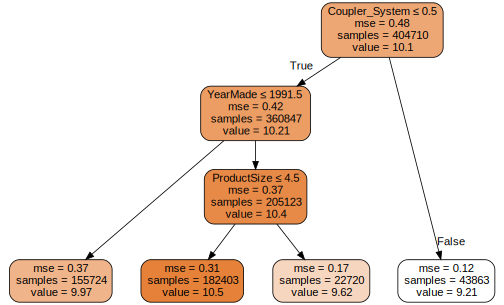

In [ ]:
draw_tree(m, xs, size=7, leaves_parallel=True, precision=2)

Understanding this picture is one of the best ways to understand decision trees, so we will start at the top and explain each part step by step.


理解这张图片是理解决策树的最好方法之一，所以我们将从顶部开始，一步一步地解释每个部分。[机器翻译]

The top node represents the *initial model* before any splits have been done, when all the data is in one group. This is the simplest possible model. It is the result of asking zero questions and will always predict the value to be the average value of the whole dataset. In this case, we can see it predicts a value of 10.10 for the logarithm of the sales price. It gives a mean squared error of 0.48. The square root of this is 0.69. (Remember that unless you see `m_rmse`, or a *root mean squared error*, then the value you are looking at is before taking the square root, so it is just the average of the square of the differences.) We can also see that there are 404,710 auction records in this group—that is the total size of our training set. The final piece of information shown here is the decision criterion for the best split that was found, which is to split based on the `coupler_system` column.


当所有数据都在一个组中时，顶部节点表示在完成任何拆分之前的 * 初始模型 *。这是可能的最简单的模型。它是提出零问题的结果，并将始终预测该值为整个数据集的平均值。在这种情况下，我们可以看到它预测销售价格的对数值为10.10。它给出了0.48的均方误差。这个的平方根是0.69。(请记住，除非您看到 'm_rmse' 或 * 均方根误差 *，否则您正在查看的值是在取平方根之前，所以它只是差的平方的平均值。)我们还可以看到这个组有404,710个拍卖记录 -- 这是我们训练集的总规模。这里显示的最后一条信息是找到的最佳拆分的决策标准，即基于 “coupler_system” 列进行拆分。[机器翻译]

Moving down and to the left, this node shows us that there were 360,847 auction records for equipment where `coupler_system` was less than 0.5. The average value of our dependent variable in this group is 10.21. Moving down and to the right from the initial model takes us to the records where `coupler_system` was greater than 0.5.


向下和向左移动，这个节点向我们展示了 “coupler_system” 小于360,847的设备的0.5个拍卖记录。我们这一组因变量的平均值是10.21。从初始模型向下和向右移动会将我们带到 'coupler_system' 大于0.5的记录。[机器翻译]

The bottom row contains our *leaf nodes*: the nodes with no answers coming out of them, because there are no more questions to be answered. At the far right of this row is the node containing records where `coupler_system` was greater than 0.5. The average value here is 9.21, so we can see the decision tree algorithm did find a single binary decision that separated high-value from low-value auction results. Asking only about `coupler_system` predicts an average value of 9.21 versus 10.1.


最下面的一行包含我们的 * 叶节点 *: 没有答案的节点，因为没有更多的问题需要回答。该行最右边的节点包含 “coupler_system” 大于0.5的记录。这里的平均值是9.21，因此我们可以看到决策树算法确实找到了将高值和低值拍卖结果分开的单个二进制决策。仅询问 'coupler_system' 预测的平均值为9.21与10.1。[机器翻译]

Returning back to the top node after the first decision point, we can see that a second binary decision split has been made, based on asking whether `YearMade` is less than or equal to 1991.5. For the group where this is true (remember, this is now following two binary decisions, based on `coupler_system` and `YearMade`) the average value is 9.97, and there are 155,724 auction records in this group. For the group of auctions where this decision is false, the average value is 10.4, and there are 205,123 records. So again, we can see that the decision tree algorithm has successfully split our more expensive auction records into two more groups which differ in value significantly.

回到第一个决策点之后的顶部节点，我们可以看到，基于询问 “yearmade” 是否小于或等于1991.5，已经进行了第二个二进制决策拆分。对于其中为true的组 (记住，这现在是基于 'coupler_system' 和 'yearmade' 的两个二进制决策之后)，平均值为9.97，而且这个组有155,724个拍卖记录。对于此决策为假的拍卖组，平均值为10.4，有205,123条记录。因此，我们可以再次看到，决策树算法已经成功地将我们更昂贵的拍卖记录分成两个价值显著不同的组。[机器翻译]

We can show the same information using Terence Parr's powerful [dtreeviz](https://explained.ai/decision-tree-viz/) library:

我们可以使用Terence Parr的强大 [dtreeviz]( https://explained.ai/decision-tree-viz/ ) 库:[机器翻译]

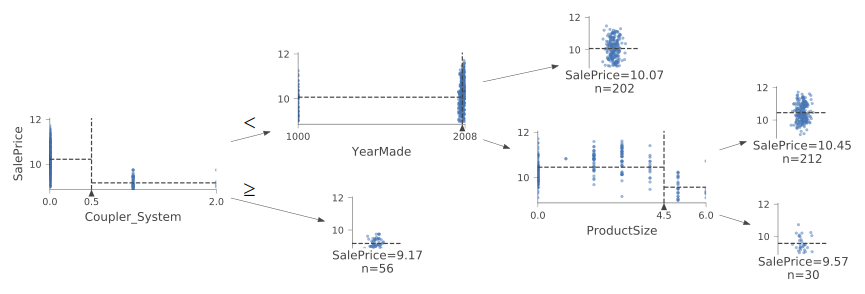

In [ ]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

This shows a chart of the distribution of the data for each split point. We can clearly see that there's a problem with our `YearMade` data: there are bulldozers made in the year 1000, apparently! Presumably this is actually just a missing value code (a value that doesn't otherwise appear in the data and that is used as a placeholder in cases where a value is missing). For modeling purposes, 1000 is fine, but as you can see this outlier makes visualization the values we are interested in more difficult. So, let's replace it with 1950:

这显示了每个拆分点的数据分布的图表。我们可以清楚地看到，我们的 “年份” 数据有一个问题: 显然，1000年有推土机!据推测，这实际上只是一个缺失的值代码 (一个不会出现在数据中的值，在值缺失的情况下用作占位符)。为了建模的目的，1000是好的，但是正如你所看到的，这个异常值使得可视化我们感兴趣的值变得更加困难。所以，让我们用1950替换它:[机器翻译]

In [ ]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

That change makes the split much clearer in the tree visualization, even although it doesn't actually change the result of the model in any significant way. This is a great example of how resilient decision trees are to data issues!

这种变化使得分割在树可视化中更加清晰，尽管它实际上并没有以任何重要的方式改变模型的结果。这是一个很好的例子，说明决策树对数据问题有多大的弹性![机器翻译]

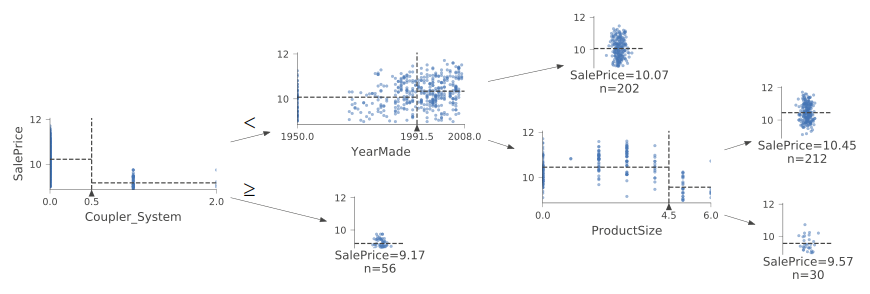

In [ ]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)

dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

Let's now have the decision tree algorithm build a bigger tree. Here, we are not passing in any stopping criteria such as `max_leaf_nodes`:

现在让决策树算法构建一个更大的树。在这里，我们没有传递任何停止标准，如 “max_leaf_nodes”:[机器翻译]

In [ ]:
m = DecisionTreeRegressor()
m.fit(xs, y);

We'll create a little function to check the root mean squared error of our model (`m_rmse`), since that's how the competition was judged:

我们将创建一个小函数来检查我们模型的均方根误差 ('m_rmse')，因为这是比赛的判断方式:[机器翻译]

In [ ]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [ ]:
m_rmse(m, xs, y)

0.0

So, our model is perfect, right? Not so fast... remember we really need to check the validation set, to ensure we're not overfitting:

所以，我们的模型是完美的，对吗？没那么快.请记住，我们确实需要检查验证集，以确保我们没有过度拟合:[机器翻译]

In [ ]:
m_rmse(m, valid_xs, valid_y)

0.337727

Oops—it looks like we might be overfitting pretty badly. Here's why:

哎呀-看起来我们可能太合身了。原因如下:[机器翻译]

In [ ]:
m.get_n_leaves(), len(xs)

(340909, 404710)

We've got nearly as many leaf nodes as data points! That seems a little over-enthusiastic. Indeed, sklearn's default settings allow it to continue splitting nodes until there is only one item in each leaf node. Let's change the stopping rule to tell sklearn to ensure every leaf node contains at least 25 auction records:

我们有几乎与数据点一样多的叶节点!这似乎有点过于热情。事实上，sklearn的默认设置允许它继续拆分节点，直到每个叶节点中只有一个项目。让我们更改停止规则，告诉sklearn确保每个叶节点至少包含25个拍卖记录:[机器翻译]

In [ ]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.248562, 0.32368)

That looks much better. Let's check the number of leaves again:

那看起来好多了。让我们再检查一下叶子的数量:[机器翻译]

In [ ]:
m.get_n_leaves()

12397

Much more reasonable!

更合理![机器翻译]

> A: Here's my intuition for an overfitting decision tree with more leaf nodes than data items. Consider the game Twenty Questions. In that game, the chooser secretly imagines an object (like, "our television set"), and the guesser gets to pose 20 yes or no questions to try to guess what the object is (like "Is it bigger than a breadbox?"). The guesser is not trying to predict a numerical value, but just to identify a particular object out of the set of all imaginable objects. When your decision tree has more leaves than there are possible objects in your domain, then it is essentially a well-trained guesser. It has learned the sequence of questions needed to identify a particular data item in the training set, and it is "predicting" only by describing that item's value. This is a way of memorizing the training set—i.e., of overfitting.

> 答: 以下是我的直觉，即过度拟合的决策树具有比数据项更多的叶节点。考虑游戏二十个问题。在那个游戏中，选择者秘密想象一个物体 (比如，“我们的电视机”)，猜测者可以提出20个是或否问题，试图猜测物体是什么 (比如 “它比面包盒大吗？”)。猜测者不是试图预测一个数值，而是从所有可以想象的对象中识别出一个特定的对象。当你的决策树的叶子比你的领域中可能的对象多，那么它本质上是一个训练有素的猜测者。它已经学习了识别训练集中特定数据项所需的问题序列，并且仅通过描述该项目的值来 “预测”。这是记忆训练set-i.e的一种方式。，过度拟合。[机器翻译]

Building a decision tree is a good way to create a model of our data. It is very flexible, since it can clearly handle nonlinear relationships and interactions between variables. But we can see there is a fundamental compromise between how well it generalizes (which we can achieve by creating small trees) and how accurate it is on the training set (which we can achieve by using large trees).


构建决策树是创建数据模型的好方法。它非常灵活，因为它可以清楚地处理变量之间的非线性关系和相互作用。但是我们可以看到它的概括程度之间有一个基本的妥协 (我们可以通过创建小树来实现) 以及它在训练集上的准确性 (我们可以通过使用大树来实现)。[机器翻译]

So how do we get the best of both worlds? We'll show you right after we handle an important missing detail: how to handle categorical variables.

那么我们如何两全其美呢？我们将在处理一个重要的缺失细节后立即向您展示: 如何处理分类变量。[机器翻译]

### Categorical Variables

# 分类变量[机器翻译]

In the previous chapter, when working with deep learning networks, we dealt with categorical variables by one-hot encoding them and feeding them to an embedding layer. The embedding layer helped the model to discover the meaning of the different levels of these variables (the levels of a categorical variable do not have an intrinsic meaning, unless we manually specify an ordering using Pandas). In a decision tree, we don't have embeddings layers—so how can these untreated categorical variables do anything useful in a decision tree? For instance, how could something like a product code be used?


在上一章中，当使用深度学习网络时，我们通过一次热编码来处理分类变量，并将它们提供给嵌入层。嵌入层帮助模型发现这些变量的不同级别的含义 (分类变量的级别没有内在含义，除非我们使用Pandas手动指定排序)。在决策树中，我们没有嵌入层 -- 那么这些未经处理的分类变量如何在决策树中做任何有用的事情呢？例如，如何使用类似产品代码的东西？[机器翻译]

The short answer is: it just works! Think about a situation where there is one product code that is far more expensive at auction than any other one. In that case, any binary split will result in that one product code being in some group, and that group will be more expensive than the other group. Therefore, our simple decision tree building algorithm will choose that split. Later during training the algorithm will be able to further split the subgroup that contains the expensive product code, and over time, the tree will home in on that one expensive product.


简短的回答是: 它只是工作!想想一个情况，有一个产品代码在拍卖中比其他任何一个都贵得多。在这种情况下，任何二进制拆分都会导致一个产品代码在某个组中，并且该组将比另一个组更昂贵。因此，我们简单的决策树构建算法将选择该拆分。稍后在训练期间，算法将能够进一步拆分包含昂贵产品代码的子组，并且随着时间的推移，树将位于该昂贵产品上。[机器翻译]

It is also possible to use one-hot encoding to replace a single categorical variable with multiple one-hot-encoded columns, where each column represents a possible level of the variable. Pandas has a `get_dummies` method which does just that.


也可以使用一热编码将单个分类变量替换为多个一热编码列，其中每列表示变量的可能级别。Pandas有一个 'get_dummies' 方法，它可以做到这一点。[机器翻译]

However, there is not really any evidence that such an approach improves the end result. So, we generally avoid it where possible, because it does end up making your dataset harder to work with. In 2019 this issue was explored in the paper ["Splitting on Categorical Predictors in Random Forests"](https://peerj.com/articles/6339/) by Marvin Wright and Inke König, which said:

然而，没有任何证据表明这种方法能改善最终结果。因此，我们通常会尽可能避免它，因为它最终会让您的数据集更难使用。在2019，这个问题在论文 [“随机森林中分类预测因子的分裂”] ( https://peerj.com/articles/6339/ ) 作者: 马文 · 赖特和印克 · 克尼格，他说:[机器翻译]

> : The standard approach for nominal predictors is to consider all $2^{k-1} − 1$ 2-partitions of the *k* predictor categories. However, this exponential relationship produces a large number of potential splits to be evaluated, increasing computational complexity and restricting the possible number of categories in most implementations. For binary classification and regression, it was shown that ordering the predictor categories in each split leads to exactly the same splits as the standard approach. This reduces computational complexity because only *k* − 1 splits have to be considered for a nominal predictor with *k* categories.

>: 标称预测器的标准方法是考虑 * k * 预测器类别的所有 $2 ^{k-1}-1 $2分区。然而，这种指数关系产生了大量需要评估的潜在分裂，增加了计算复杂性，并限制了大多数实现中可能的类别数量。对于二进制分类和回归，表明在每个分割中排序预测器类别会导致与标准方法完全相同的分割。这降低了计算复杂性，因为对于具有 * k * 类别的标称预测器，只需考虑 * k *-1分裂。[机器翻译]

Now that you understand how decisions tree work, it's time for the best-of-both-worlds solution: random forests.

现在您已经了解了decision tree是如何工作的，是时候采用两全其美的解决方案了: 随机森林。[机器翻译]

## Random Forests

# # 随机森林[机器翻译]

In 1994 Berkeley professor Leo Breiman, one year after his retirement, published a small technical report called ["Bagging Predictors"](https://www.stat.berkeley.edu/~breiman/bagging.pdf), which turned out to be one of the most influential ideas in modern machine learning. The report began:


1994，伯克利分校教授Leo Breiman，在他退休一年后，发表了一篇名为 [“Bagging predicals”] ( https://www.stat.berkeley.edu/~breiman/bagging.pdf )，这被证明是现代机器学习中最有影响力的想法之一。报告开始:[机器翻译]

> : Bagging predictors is a method for generating multiple versions of a predictor and using these to get an aggregated predictor. The aggregation averages over the versions... The multiple versions are formed by making bootstrap replicates of the learning set and using these as new learning sets. Tests… show that bagging can give substantial gains in accuracy. The vital element is the instability of the prediction method. If perturbing the learning set can cause significant changes in the predictor constructed, then bagging can improve accuracy.


>: Bagging预测器是一种生成预测器的多个版本并使用这些版本获得聚合预测器的方法。版本上的聚合平均值.通过对学习集进行引导复制并将其用作新的学习集，形成了多个版本。测试.表明装袋可以在准确性上获得实质性的收益。至关重要的因素是预测方法的不稳定性。如果扰乱学习集会导致构建的预测器发生显著变化，那么装袋可以提高准确性。[机器翻译]

Here is the procedure that Breiman is proposing:


以下是Breiman提出的程序:[机器翻译]

1. Randomly choose a subset of the rows of your data (i.e., "bootstrap replicates of your learning set").
1. Train a model using this subset.
1. Save that model, and then return to step 1 a few times.
1. This will give you a number of trained models. To make a prediction, predict using all of the models, and then take the average of each of those model's predictions.


1.随机选择数据行的子集 (即 “学习集的引导复制”)。
1.使用此子集训练模型。
1.保存该模型，然后返回步骤1几次。
1.这将为您提供一些经过培训的模型。要进行预测，请使用所有模型进行预测，然后取每个模型预测的平均值。[机器翻译]

This procedure is known as "bagging." It is based on a deep and important insight: although each of the models trained on a subset of data will make more errors than a model trained on the full dataset, those errors will not be correlated with each other. Different models will make different errors. The average of those errors, therefore, is: zero! So if we take the average of all of the models' predictions, then we should end up with a prediction that gets closer and closer to the correct answer, the more models we have. This is an extraordinary result—it means that we can improve the accuracy of nearly any kind of machine learning algorithm by training it multiple times, each time on a different random subset of the data, and averaging its predictions.


这个程序被称为 “装袋”。它基于一个深刻而重要的洞察力: 尽管在数据子集上训练的每个模型比在完整数据集上训练的模型会产生更多的错误，这些错误不会相互关联。不同的模型会产生不同的误差。因此，这些错误的平均值是: 零!因此，如果我们取所有模型预测的平均值，那么我们最终应该得到一个越来越接近正确答案的预测，我们拥有的模型越多。这是一个非同寻常的结果 -- 这意味着我们可以通过多次训练来提高几乎任何类型的机器学习算法的准确性，每次都是在不同的随机数据子集上，并对其预测进行平均。[机器翻译]

In 2001 Leo Breiman went on to demonstrate that this approach to building models, when applied to decision tree building algorithms, was particularly powerful. He went even further than just randomly choosing rows for each model's training, but also randomly selected from a subset of columns when choosing each split in each decision tree. He called this method the *random forest*. Today it is, perhaps, the most widely used and practically important machine learning method.


在2001，Leo Breiman继续证明这种构建模型的方法，当应用于决策树构建算法时，是特别强大的。他不仅为每个模型的训练随机选择行，而且在选择每个决策树中的每个分割时也从列的子集中随机选择。他把这个方法称为 * 随机森林 *。今天，它可能是最广泛使用和实际重要的机器学习方法。[机器翻译]

In essence a random forest is a model that averages the predictions of a large number of decision trees, which are generated by randomly varying various parameters that specify what data is used to train the tree and other tree parameters. Bagging is a particular approach to "ensembling," or combining the results of multiple models together. To see how it works in practice, let's get started on creating our own random forest!

本质上，随机森林是对大量决策树的预测进行平均的模型，它们是通过随机变化的各种参数生成的，这些参数指定用于训练树的数据和其他树参数。装袋是一种 “组合” 或将多个模型的结果结合在一起的特殊方法。要了解它在实践中是如何工作的，让我们开始创建我们自己的随机森林吧![机器翻译]

In [ ]:
#hide
# pip install —pre -f https://sklearn-nightly.scdn8.secure.raxcdn.com scikit-learn —U

### Creating a Random Forest

# 创建随机森林[机器翻译]

We can create a random forest just like we created a decision tree, except now, we are also specifying parameters that indicate how many trees should be in the forest, how we should subset the data items (the rows), and how we should subset the fields (the columns).


我们可以创建一个随机森林，就像我们创建了一个决策树一样，除了现在，我们还指定了指示森林中应该有多少棵树的参数，我们应该如何子集数据项 (行)，以及我们应该如何子集字段 (列)。[机器翻译]

In the following function definition `n_estimators` defines the number of trees we want, `max_samples` defines how many rows to sample for training each tree, and `max_features` defines how many columns to sample at each split point (where `0.5` means "take half the total number of columns"). We can also specify when to stop splitting the tree nodes, effectively limiting the depth of the tree, by including the same `min_samples_leaf` parameter we used in the last section. Finally, we pass `n_jobs=-1` to tell sklearn to use all our CPUs to build the trees in parallel. By creating a little function for this, we can more quickly try different variations in the rest of this chapter:

在下面的函数定义中，'n_estimators' 定义了我们想要的树的数量，'max_samples' 定义了要采样多少行来训练每棵树，和 “max_features” 定义了在每个分割点采样多少列 (其中 “0.5” 表示 “取总列数的一半”)。我们还可以指定何时停止分割树节点，通过包含我们在最后一节中使用的相同的 “min_samples_leaf” 参数来有效地限制树的深度。最后，我们通过 'n_jobs =-1' 告诉sklearn使用我们所有的cpu并行构建树。通过为此创建一个小函数，我们可以在本章的其余部分更快地尝试不同的变体:[机器翻译]

In [ ]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [ ]:
m = rf(xs, y);

Our validation RMSE is now much improved over our last result produced by the `DecisionTreeRegressor`, which made just one tree using all the available data:

我们的验证RMSE现在比我们最后一个由 “decisiontreeregressor” 产生的结果有了很大的改进，它使用所有可用的数据只产生了一棵树:[机器翻译]

In [ ]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.170896, 0.233502)

One of the most important properties of random forests is that they aren't very sensitive to the hyperparameter choices, such as `max_features`. You can set `n_estimators` to as high a number as you have time to train—the more trees you have, the more accurate the model will be. `max_samples` can often be left at its default, unless you have over 200,000 data points, in which case setting it to 200,000 will make it train faster with little impact on accuracy. `max_features=0.5` and `min_samples_leaf=4` both tend to work well, although sklearn's defaults work well too.


随机森林最重要的属性之一是它们对超参数选择不太敏感，例如 'max_features'。你可以将 “n _ 估计量” 设置为你有时间训练的数字 -- 你拥有的树越多，模型就越准确。“Max_samples” 通常可以保留为默认值，除非您有超过200,000个数据点，在这种情况下，将其设置为200,000将使其训练更快，而对精度影响很小。'max_features = 0.5' 和 'min_samples_leaf = 4' 两者都倾向于很好地工作，尽管sklearn的默认值也很好。[机器翻译]

The sklearn docs [show an example](http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html) of the effects different `max_features` choices, with increasing numbers of trees. In the plot, the blue plot line uses the fewest features and the green line uses the most (it uses all the features). As you can see in <<max_features>>, the models with the lowest error result from using a subset of features but with a larger number of trees.

Sklearn文档 [显示示例] ( http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html ) 的效果不同的 'max_features' 选择，随着树木数量的增加。在绘图中，蓝色绘图线使用最少的要素，而绿色线使用最多 (它使用所有要素)。正如您在 <<max_features>> 中看到的，误差最低的模型是使用特征子集但树数量较多的结果。[机器翻译]

<img alt="sklearn max_features chart" width="500" caption="Error based on max features and number of trees (source: https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html)" src="images/sklearn_features.png" id="max_features"/>

<Img alt = "sklearn max_features chart" width = "500" caption = "基于最大特征和树数的错误 (来源: https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html ) "Src =" images/sklearn_features.png "id =" max_features "/>[机器翻译]

To see the impact of `n_estimators`, let's get the predictions from each individual tree in our forest (these are in the `estimators_` attribute):

要查看 “n_estimators” 的影响，让我们从森林中的每个单独的树中获取预测 (这些在 “estimators _” 属性中):[机器翻译]

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

As you can see, `preds.mean(0)` gives the same results as our random forest:

正如你所看到的，'preds.mean(0)' 给出了与我们的随机森林相同的结果:[机器翻译]

In [ ]:
r_mse(preds.mean(0), valid_y)

0.233502

Let's see what happens to the RMSE as we add more and more trees. As you can see, the improvement levels off quite a bit after around 30 trees:

让我们看看随着我们添加越来越多的树，RMSE会发生什么。正如你所看到的，在大约30棵树之后，改进水平下降了很多:[机器翻译]

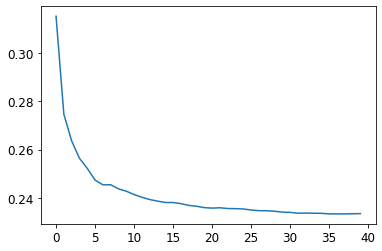

In [ ]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

The performance on our validation set is worse than on our training set. But is that because we're overfitting, or because the validation set covers a different time period, or a bit of both? With the existing information we've seen, we can't tell. However, random forests have a very clever trick called *out-of-bag* (OOB) error that can help us with this (and more!).

我们的验证集的性能比我们的训练集差。但是这是因为我们过度拟合，还是因为验证集覆盖了不同的时间段，或者两者都有？根据我们所看到的现有信息，我们无法分辨。然而，随机森林有一个非常聪明的技巧，叫做 * out-of-bag * (OOB) 错误，可以帮助我们解决这个问题 (以及更多!)。[机器翻译]

### Out-of-Bag Error

# 出包错误[机器翻译]

Recall that in a random forest, each tree is trained on a different subset of the training data. The OOB error is a way of measuring prediction error on the training set by only including in the calculation of a row's error trees where that row was *not* included in training. This allows us to see whether the model is overfitting, without needing a separate validation set.


回想一下，在随机森林中，每个树都在训练数据的不同子集上进行训练。OOB错误是一种测量训练集上预测错误的方法，方法是只在计算行的错误树时包括该行 * 不 * 包含在训练中。这允许我们查看模型是否过拟合，而不需要单独的验证集。[机器翻译]

> A: My intuition for this is that, since every tree was trained with a different randomly selected subset of rows, out-of-bag error is a little like imagining that every tree therefore also has its own validation set. That validation set is simply the rows that were not selected for that tree's training.


> 答: 我的直觉是，由于每棵树都是用不同的随机选择的行子集训练的，出包错误有点像想象，因此每棵树也有自己的验证集。该验证集只是没有为该树的训练选择的行。[机器翻译]

This is particularly beneficial in cases where we have only a small amount of training data, as it allows us to see whether our model generalizes without removing items to create a validation set. The OOB predictions are available in the `oob_prediction_` attribute. Note that we compare them to the training labels, since this is being calculated on trees using the training set.

这在我们只有少量训练数据的情况下特别有益，因为它允许我们查看我们的模型是否可以在不删除项目的情况下进行概括来创建验证集。OOB预测在 “oob_prediction _” 属性中可用。请注意，我们将它们与训练标签进行比较，因为这是使用训练集在树上计算的。[机器翻译]

In [ ]:
r_mse(m.oob_prediction_, y)

0.210686

We can see that our OOB error is much lower than our validation set error. This means that something else is causing that error, in *addition* to normal generalization error. We'll discuss the reasons for this later in this chapter.

我们可以看到我们的OOB错误比我们的验证集错误低得多。这意味着除了正常的泛化错误之外，还有其他原因导致了这个错误。我们将在本章后面讨论原因。[机器翻译]

This is one way to interpret our model's predictions—let's focus on more of those now.

这是解释我们模型预测的一种方式 -- 让我们现在关注更多的预测。[机器翻译]

## Model Interpretation

# # 模型解释[机器翻译]

For tabular data, model interpretation is particularly important. For a given model, the things we are most likely to be interested in are:


对于表格数据，模型解释尤为重要。对于给定的模型，我们最可能感兴趣的是:[机器翻译]

- How confident are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
- Which columns are the strongest predictors, which can we ignore?
- Which columns are effectively redundant with each other, for purposes of prediction?
- How do predictions vary, as we vary these columns?


-我们对使用特定一行数据的预测有多大信心？
-对于使用特定数据行进行预测，最重要的因素是什么，它们如何影响预测？
-哪些列是最强的预测，我们可以忽略哪些？
-为了预测的目的，哪些列实际上是相互冗余的？
-预测如何变化，因为我们改变了这些列？[机器翻译]

As we will see, random forests are particularly well suited to answering these questions. Let's start with the first one!

正如我们将看到的，随机森林特别适合回答这些问题。让我们从第一个开始![机器翻译]

### Tree Variance for Prediction Confidence

# 预测置信度的树方差[机器翻译]

We saw how the model averages the individual tree's predictions to get an overall prediction—that is, an estimate of the value. But how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions across the trees, instead of just the mean. This tells us the *relative* confidence of predictions. In general, we would want to be more cautious of using the results for rows where trees give very different results (higher standard deviations), compared to cases where they are more consistent (lower standard deviations).


我们看到了模型如何对单个树的预测进行平均，以获得总体预测，即对值的估计。但是我们怎么知道估计的信心呢？一个简单的方法是使用跨树预测的标准偏差，而不仅仅是平均值。这告诉我们预测的 * 相对 * 置信度。一般来说，我们希望更加谨慎地使用树木产生非常不同结果 (更高的标准差) 的行的结果，与它们更一致的情况相比 (更低的标准差)。[机器翻译]

In the earlier section on creating a random forest, we saw how to get predictions over the validation set, using a Python list comprehension to do this for each tree in the forest:

在前面关于创建随机森林的章节中，我们看到了如何通过验证集获取预测，使用Python列表理解为森林中的每棵树执行此操作:[机器翻译]

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [ ]:
preds.shape

(40, 7988)

Now we have a prediction for every tree and every auction (40 trees and 7,988 auctions) in the validation set.


现在我们对验证集中的每棵树和每一次拍卖 (40棵树和7,988次拍卖) 都有一个预测。[机器翻译]

Using this we can get the standard deviation of the predictions over all the trees, for each auction:

使用这个，我们可以得到所有树的预测的标准偏差，对于每次拍卖:[机器翻译]

In [ ]:
preds_std = preds.std(0)

Here are the standard deviations for the predictions for the first five auctions—that is, the first five rows of the validation set:

以下是前五次拍卖预测的标准差，即验证集的前五行:[机器翻译]

In [ ]:
preds_std[:5]

array([0.21529149, 0.10351274, 0.08901878, 0.28374773, 0.11977206])

As you can see, the confidence in the predictions varies widely. For some auctions, there is a low standard deviation because the trees agree. For others it's higher, as the trees don't agree. This is information that would be useful in a production setting; for instance, if you were using this model to decide what items to bid on at auction, a low-confidence prediction might cause you to look more carefully at an item before you made a bid.

如你所见，对预测的信心差异很大。对于一些拍卖，标准偏差很低，因为树木同意。对其他人来说，它更高，因为树不同意。这是在生产环境中有用的信息; 例如，如果你使用这个模型来决定拍卖哪些物品，低置信度预测可能会导致您在出价之前更仔细地查看项目。[机器翻译]

### Feature Importance

# 特性重要性[机器翻译]

It's not normally enough to just to know that a model can make accurate predictions—we also want to know *how* it's making predictions. *feature importance* gives us insight into this. We can get these directly from sklearn's random forest by looking in the `feature_importances_` attribute. Here's a simple function we can use to pop them into a DataFrame and sort them:

仅仅知道一个模型可以做出准确的预测通常是不够的 -- 我们也想知道它是如何做出预测的。* 功能重要性 * 让我们深入了解这一点。我们可以通过查看 'feature_importances _' 属性直接从sklearn的随机森林中获取这些。下面是一个简单的函数，我们可以使用它将它们弹出到一个DataFrame中并对它们进行排序:[机器翻译]

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

The feature importances for our model show that the first few most important columns have much higher importance scores than the rest, with (not surprisingly) `YearMade` and `ProductSize` being at the top of the list:

我们模型的特征重要性显示，前几个最重要的列的重要性分数比其他列高得多，“yearmade” 和 “product size” 位于列表的顶部 (不足为奇):[机器翻译]

In [ ]:
fi = rf_feat_importance(m, xs)
fi[:10]

cols       imp
69            YearMade  0.182890
6          ProductSize  0.127268
30      Coupler_System  0.117698
7   fiProductClassDesc  0.069939
66             ModelID  0.057263
77         saleElapsed  0.050113
32     Hydraulics_Flow  0.047091
3      fiSecondaryDesc  0.041225
31      Grouser_Tracks  0.031988
1          fiModelDesc  0.031838

A plot of the feature importances shows the relative importances more clearly:

特征导入图更清楚地显示了相对导入:[机器翻译]

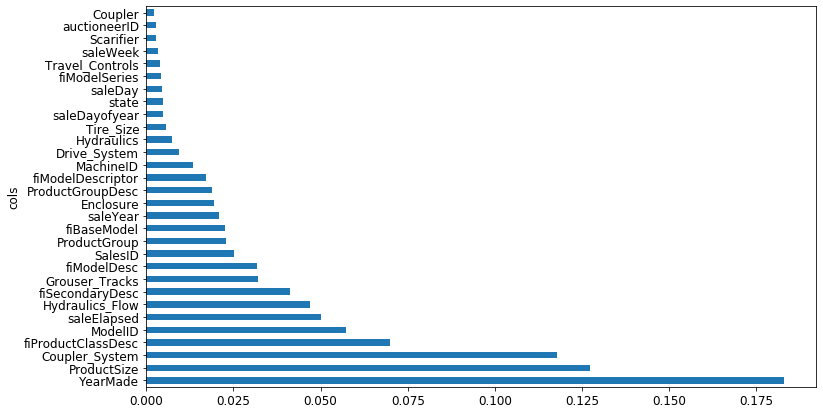

In [ ]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

The way these importances are calculated is quite simple yet elegant. The feature importance algorithm loops through each tree, and then recursively explores each branch. At each branch, it looks to see what feature was used for that split, and how much the model improves as a result of that split. The improvement (weighted by the number of rows in that group) is added to the importance score for that feature. This is summed across all branches of all trees, and finally the scores are normalized such that they add to 1.

这些重要性的计算方式非常简单而优雅。特征重要性算法循环遍历每个树，然后递归地探索每个分支。在每个分支上，它会查看该拆分使用了哪些功能，以及该拆分导致的模型改进程度。改进 (由该组中的行数加权) 将添加到该功能的重要性得分中。这是在所有树的所有分支中求和的，最后将分数标准化，使其加到1。[机器翻译]

### Removing Low-Importance Variables

# 移除低重要性变量[机器翻译]

It seems likely that we could use just a subset of the columns by removing the variables of low importance and still get good results. Let's try just keeping those with a feature importance greater than 0.005:

似乎我们可以通过移除低重要性的变量来使用列的子集，并且仍然可以获得好的结果。让我们试着保持那些功能重要性大于0.005的:[机器翻译]

In [ ]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

21

We can retrain our model using just this subset of the columns:

我们可以使用这些列的子集来重新训练我们的模型:[机器翻译]

In [ ]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [ ]:
m = rf(xs_imp, y)

And here's the result:

结果是:[机器翻译]

In [ ]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.181208, 0.232323)

Our accuracy is about the same, but we have far fewer columns to study:

我们的准确性大致相同，但我们要研究的列要少得多:[机器翻译]

In [ ]:
len(xs.columns), len(xs_imp.columns)

(78, 21)

We've found that generally the first step to improving a model is simplifying it—78 columns was too many for us to study them all in depth! Furthermore, in practice often a simpler, more interpretable model is easier to roll out and maintain.


我们发现，一般来说，改进模型的第一步是简化它 -- 78列太多了，我们无法深入研究它们!此外，在实践中，通常更简单、更可解释的模型更容易推出和维护。[机器翻译]

This also makes our feature importance plot easier to interpret. Let's look at it again:

这也使我们的特征重要性图更容易解释。让我们再看一遍:[机器翻译]

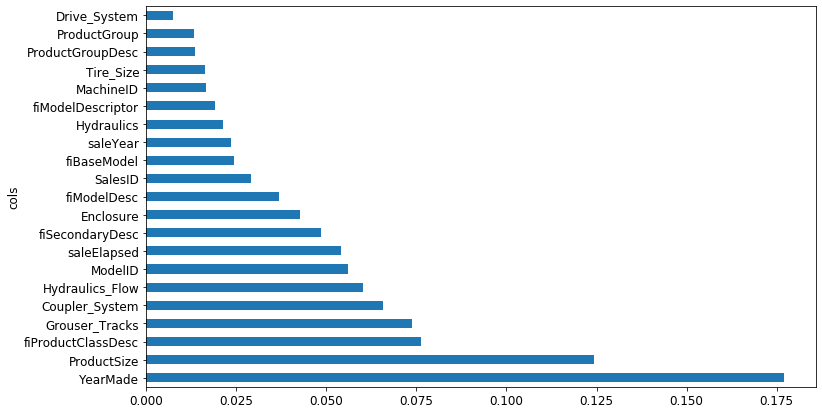

In [ ]:
plot_fi(rf_feat_importance(m, xs_imp));

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings: for example, `ProductGroup` and `ProductGroupDesc`. Let's try to remove any redundent features. 

让这一点更难解释的一件事是，似乎有一些含义非常相似的变量: 例如，“productgroup” 和 “productgroupdesc”。让我们尝试删除任何冗余功能。[机器翻译]

### Removing Redundant Features

# 移除冗余特性[机器翻译]

Let's start with:

让我们从以下内容开始:[机器翻译]

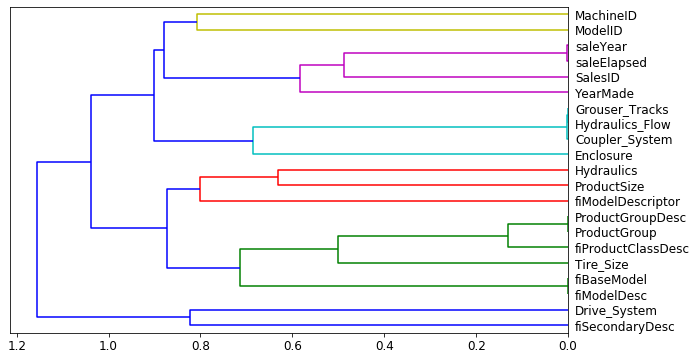

In [ ]:
cluster_columns(xs_imp)

In this chart, the pairs of columns that are most similar are the ones that were merged together early, far from the "root" of the tree at the left. Unsurprisingly, the fields `ProductGroup` and `ProductGroupDesc` were merged quite early, as were `saleYear` and `saleElapsed` and `fiModelDesc` and `fiBaseModel`. These might be so closely correlated they are practically synonyms for each other.


在此图表中，最相似的列对是早期合并在一起的列，远离左侧树的 “根”。不出所料，“productgroup” 和 “productgroupdesc” 字段很早就合并了，“saleyear” 和 “saleelapsed” 、 “fibasemodel” 也是如此。这些可能是如此密切相关，他们实际上是彼此的同义词。[机器翻译]

> note: Determining Similarity: The most similar pairs are found by calculating the _rank correlation_, which means that all the values are replaced with their _rank_ (i.e., first, second, third, etc. within the column), and then the _correlation_ is calculated. (Feel free to skip over this minor detail though, since it's not going to come up again in the book!)


> 注意: 确定相似性: 通过计算 _ rank相关 _ 找到最相似的对，这意味着所有的值都被它们的 _ rank _ (i.e.，列内第一、第二、第三等)，然后计算 _ correlation _。(不过，请随意跳过这个小细节，因为它不会在书中再次出现!)[机器翻译]

Let's try removing some of these closely related features to see if the model can be simplified without impacting the accuracy. First, we create a function that quickly trains a random forest and returns the OOB score, by using a lower `max_samples` and higher `min_samples_leaf`. The OOB score is a number returned by sklearn that ranges between 1.0 for a perfect model and 0.0 for a random model. (In statistics it's called *R^2*, although the details aren't important for this explanation.) We don't need it to be very accurate—we're just going to use it to compare different models, based on removing some of the possibly redundant columns:

让我们尝试删除其中一些密切相关的特征，看看是否可以在不影响准确性的情况下简化模型。首先，我们创建一个函数，通过使用较低的 'max_samples' 和较高的 'min_samples_leaf' 来快速训练随机森林并返回OOB分数。OOB分数是sklearn返回的数字，范围在完美模型的1.0和随机模型的0.0之间。(在统计学中，它被称为 * R ^ 2 *，尽管细节对于这个解释并不重要。)我们不需要它非常精确 -- 我们只是用它来比较不同的模型，基于删除一些可能多余的列:[机器翻译]

In [ ]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

Here's our baseline:

以下是我们的基线:[机器翻译]

In [ ]:
get_oob(xs_imp)

0.8771039618198545

Now we try removing each of our potentially redundant variables, one at a time:

现在我们尝试删除每个潜在的冗余变量，一次一个:[机器翻译]

In [ ]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'saleYear': 0.8759666979317242,
 'saleElapsed': 0.8728423449081594,
 'ProductGroupDesc': 0.877877012281002,
 'ProductGroup': 0.8772503407182847,
 'fiModelDesc': 0.8756415073829513,
 'fiBaseModel': 0.8765165299438019,
 'Hydraulics_Flow': 0.8778545895742573,
 'Grouser_Tracks': 0.8773718142788077,
 'Coupler_System': 0.8778016988955392}

Now let's try dropping multiple variables. We'll drop one from each of the tightly aligned pairs we noticed earlier. Let's see what that does:

现在让我们尝试删除多个变量。我们将从我们之前注意到的每个紧密对齐的配对中删除一个。让我们看看它的作用:[机器翻译]

In [ ]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8739605718147015

Looking good! This is really not much worse than the model with all the fields. Let's create DataFrames without these columns, and save them:

好看!这真的没有比所有字段的模型差多少。让我们创建不带这些列的dataframe，并保存它们:[机器翻译]

In [ ]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [ ]:
(path/'xs_final.pkl').save(xs_final)
(path/'valid_xs_final.pkl').save(valid_xs_final)

We can load them back later with:

我们可以稍后用以下内容加载它们:[机器翻译]

In [ ]:
xs_final = (path/'xs_final.pkl').load()
valid_xs_final = (path/'valid_xs_final.pkl').load()

Now we can check our RMSE again, to confirm that the accuracy hasn't substantially changed.

现在我们可以再次检查我们的RMSE，以确认准确性没有实质性变化。[机器翻译]

In [ ]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.183263, 0.233846)

By focusing on the most important variables, and removing some redundant ones, we've greatly simplified our model. Now, let's see how those variables affect our predictions using partial dependence plots.

通过关注最重要的变量，并删除一些多余的变量，我们大大简化了我们的模型。现在，让我们看看这些变量如何使用部分依赖图影响我们的预测。[机器翻译]

### Partial Dependence

# 部分依赖[机器翻译]

As we've seen, the two most important predictors are `ProductSize` and `YearMade`. We'd like to understand the relationship between these predictors and sale price. It's a good idea to first check the count of values per category (provided by the Pandas `value_counts` method), to see how common each category is:

正如我们所见，两个最重要的预测因素是 “产品尺寸” 和 “年份”。我们想了解这些预测因素和销售价格之间的关系。首先检查每个类别的值计数 (由Pandas 'value_counts' 方法提供) 是一个好主意，以了解每个类别的常见程度:[机器翻译]

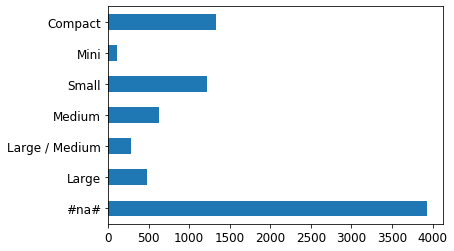

In [ ]:
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c);

The largrest group is `#na#`, which is the label fastai applies to missing values.


Largrest组是 '# na #'，这是fastai应用于缺失值的标签。[机器翻译]

Let's do the same thing for `YearMade`. Since this is a numeric feature, we'll need to draw a histogram, which groups the year values into a few discrete bins:

让我们为 “yearmade” 做同样的事情。由于这是一个数字特征，我们需要绘制一个直方图，将年份值分组到几个离散的箱中:[机器翻译]

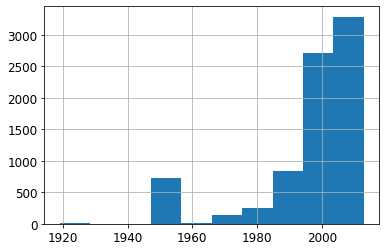

In [ ]:
ax = valid_xs_final['YearMade'].hist()

Other than the special value 1950 which we used for coding missing year values, most of the data is from after 1990.


除了我们用于编码缺失年份值的特殊值1950之外，大部分数据来自1990年后。[机器翻译]

Now we're ready to look at *partial dependence plots*. Partial dependence plots try to answer the question: if a row varied on nothing other than the feature in question, how would it impact the dependent variable?


现在我们准备看 * 部分依赖图 *。部分依赖图试图回答这个问题: 如果一行除了所讨论的特征之外没有任何变化，它将如何影响因变量？[机器翻译]

For instance, how does `YearMade` impact sale price, all other things being equal?


例如，在所有其他条件相同的情况下，“年制” 如何影响销售价格？[机器翻译]

To answer this question, we can't just take the average sale price for each `YearMade`. The problem with that approach is that many other things vary from year to year as well, such as which products are sold, how many products have air-conditioning, inflation, and so forth. So, merely averaging over all the auctions that have the same `YearMade` would also capture the effect of how every other field also changed along with `YearMade` and how that overall change affected price.


要回答这个问题，我们不能只取每个 “年份” 的平均销售价格。这种方法的问题是，许多其他事情每年都有所不同，比如销售哪些产品，有多少产品有空调，通货膨胀等等。因此，仅仅平均所有具有相同 “年份” 的拍卖也将捕捉其他领域如何随着 “年份” 变化以及整体变化如何影响价格的影响。[机器翻译]

Instead, what we do is replace every single value in the `YearMade` column with 1950, and then calculate the predicted sale price for every auction, and take the average over all auctions. Then we do the same for 1951, 1952, and so forth until our final year of 2011. This isolates the effect of only `YearMade` (even if it does so by averaging over some imagined records where we assign a `YearMade` value that might never actually exist alongside some other values). 


相反，我们所做的是用1950替换 “yearmade” 列中的每个单个值，然后计算每次拍卖的预测销售价格，并对所有拍卖取平均值。然后我们对1951、1952等做同样的事情，直到2011年的最后一年。这隔离了只有 “年份” 的影响 (即使它通过对一些想象的记录进行平均来实现，在这些记录中，我们分配了一个 “年份” 值，而这个值可能永远不会与其他值一起存在)。[机器翻译]

> A: If you are philosophically minded it is somewhat dizzying to contemplate the different kinds of hypotheticality that we are juggling to make this calculation. First, there's the fact that _every_ prediction is hypothetical, because we are not noting empirical data. Second, there's the point that we're _not_ merely interested in asking how sale price would change if we changed `YearMade` and everything else along with it. Rather, we're very specifically asking, how sale price would change in a hypothetical world where only `YearMade` changed. Phew! It is impressive that we can ask such questions. I recommend Judea Pearl and Dana Mackenzie's recent book on causality, _The Book of Why_ (Basic Books), if you're interested in more deeply exploring formalisms for analyzing these subtleties.


> 答: 如果你有哲学头脑，思考我们正在杂耍进行计算的不同类型的假设有点令人眼花缭乱。首先，每个预测都是假设的，因为我们没有注意到经验数据。其次，有一点是，如果我们改变了 “yearmade” 和其他一切，我们不仅仅只是想问销售价格会如何变化。相反，我们非常具体地问，在一个只有 “年制” 变化的假设世界中，销售价格会如何变化。唷!令人印象深刻的是，我们可以提出这样的问题。如果你有兴趣更深入地探索分析这些微妙之处的形式论，我推荐Judea Pearl和Dana Mackenzie最近关于因果关系的书 -- 《为什么的书》 (基础书)。[机器翻译]

With these averages, we can then plot each of these years on the x-axis, and each of the predictions on the y-axis. This, finally, is a partial dependence plot. Let's take a look:

有了这些平均值，我们就可以在x轴上绘制这些年的每一年，并在y轴上绘制每个预测。最后，这是一个部分依赖的情节。让我们看看:[机器翻译]

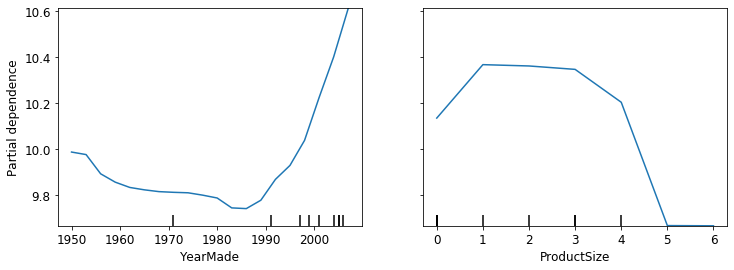

In [ ]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final, ['YearMade','ProductSize'],
                        grid_resolution=20, ax=ax);

Looking first of all at the `YearMade` plot, and specifically at the section covering the years after 1990 (since as we noted this is where we have the most data), we can see a nearly linear relationship between year and price. Remember that our dependent variable is after taking the logarithm, so this means that in practice there is an exponential increase in price. This is what we would expect: depreciation is generally recognized as being a multiplicative factor over time, so, for a given sale date, varying year made ought to show an exponential relationship with sale price.


首先看 “年制” 图，特别是1990年后的部分 (因为正如我们所指出的，这是我们拥有最多数据的地方)，我们可以看到年份和价格之间几乎是线性关系。请记住，我们的因变量是在取对数之后，所以这意味着在实践中价格呈指数增长。这就是我们所期望的: 折旧通常被认为是随着时间的推移的乘法因素，因此，对于给定的销售日期，不同的年份应该显示出与销售价格的指数关系。[机器翻译]

The `ProductSize` partial plot is a bit concerning. It shows that the final group, which we saw is for missing values, has the lowest price. To use this insight in practice, we would want to find out *why* it's missing so often, and what that *means*. Missing values can sometimes be useful predictors—it entirely depends on what causes them to be missing. Sometimes, however, they can indicate *data leakage*.

“产品尺寸” 部分情节有点令人担忧。它显示我们看到的最后一组是缺失值，价格最低。为了在实践中使用这种洞察力，我们想找出 * 为什么 * 它经常丢失，以及 * 意味着什么 *。缺失值有时可能是有用的预测因子 -- 这完全取决于是什么导致它们缺失。然而，有时它们可以指示 * 数据泄漏 *。[机器翻译]

### Data Leakage

# 数据泄露[机器翻译]

In  the paper ["Leakage in Data Mining: Formulation, Detection, and Avoidance"](https://dl.acm.org/doi/10.1145/2020408.2020496), Shachar Kaufman, Saharon Rosset, and Claudia Perlich describe leakage as: 


在论文 [“数据挖掘中的泄漏: 制定、检测和避免”] ( https://dl.acm.org/doi/10.1145/2020408.2020496 )，Shachar Kaufman，Saharon Rosset和Claudia Perlich将泄漏描述为:[机器翻译]

> : The introduction of information about the target of a data mining problem, which should not be legitimately available to mine from. A trivial example of leakage would be a model that uses the target itself as an input, thus concluding for example that 'it rains on rainy days'. In practice, the introduction of this illegitimate information is unintentional, and facilitated by the data collection, aggregation and preparation process.


>: 关于数据挖掘问题目标的信息的介绍，这些信息不应该合法地用于挖掘。泄漏的一个微不足道的例子是一个使用目标本身作为输入的模型，从而得出结论，例如 “雨天下雨”。在实践中，这种非法信息的引入是无意的，并由数据收集、汇总和准备过程提供便利。[机器翻译]

They give as an example:


他们举个例子:[机器翻译]

> : A real-life business intelligence project at IBM where potential customers for certain products were identified, among other things, based on keywords found on their websites. This turned out to be leakage since the website content used for training had been sampled at the point in time where the potential customer has already become a customer, and where the website contained traces of the IBM products purchased, such as the word 'Websphere' (e.g., in a press release about the purchase or a specific product feature the client uses).


>: IBM的一个现实商业智能项目，其中某些产品的潜在客户是根据他们网站上的关键词来识别的。这是泄露，因为用于培训的网站内容已经在潜在客户已经成为客户的时间点进行了采样，以及网站包含所购买的IBM产品的痕迹，例如单词 “websphere” (e.g.，在关于购买或客户使用的特定产品功能的新闻稿中)。[机器翻译]

Data leakage is subtle and can take many forms. In particular, missing values often represent data leakage.


数据泄露是微妙的，可以采取多种形式。特别是，缺失值通常表示数据泄露。[机器翻译]

For instance, Jeremy competed in a Kaggle competition designed to predict which researchers would end up receiving research grants. The information was provided by a university and included thousands of examples of research projects, along with information about the researchers involved and data on whether or not each grant was eventually accepted. The university hoped to be able to use the models developed in this competition to rank which grant applications were most likely to succeed, so it could prioritize its processing.


例如，杰里米参加了一项旨在预测哪些研究人员最终会获得研究资助的卡格尔竞赛。这些信息是由一所大学提供的，包括数千个研究项目的例子，以及关于所涉及的研究人员的信息和关于每项资助是否最终被接受的数据。该大学希望能够使用在这场比赛中开发的模型来排名哪些赠款申请最有可能成功，因此它可以优先处理。[机器翻译]

Jeremy used a random forest to model the data, and then used feature importance to find out which features were most predictive. He noticed three surprising things:


Jeremy使用随机森林对数据进行建模，然后使用特征重要性找出哪些特征最具预测性。他注意到三件令人惊讶的事情:[机器翻译]

- The model was able to correctly predict who would receive grants over 95% of the time.
- Apparently meaningless identifier columns were the most important predictors.
- The day of week and day of year columns were also highly predictive; for instance, the vast majority of grant applications dated on a Sunday were accepted, and many accepted grant applications were dated on January 1.


-该模型能够正确预测谁将在95% 的时间内获得资助。
-显然无意义的标识符列是最重要的预测因素。
-星期几和一年中的日子列也具有高度预测性; 例如，绝大多数在星期日的资助申请被接受，许多被接受的赠款申请日期是1月1日。[机器翻译]

For the identifier columns, one partial dependence plot per column showed that when the information was missing the application was almost always rejected. It turned out that in practice, the university only filled out much of this information *after* a grant application was accepted. Often, for applications that were not accepted, it was just left blank. Therefore, this information was not something that was actually available at the time that the application was received, and it would not be available for a predictive model—it was data leakage.


对于标识符列，每个列的部分依赖关系图显示，当信息丢失时，应用程序几乎总是被拒绝。事实证明，在实践中，大学只在 * 接受资助申请后 * 填写了大部分信息。通常，对于不被接受的申请，它只是空白的。因此，这些信息在收到应用程序时实际上不是可用的，也不可用于预测模型 -- 这是数据泄露。[机器翻译]

In the same way, the final processing of successful applications was often done automatically as a batch at the end of the week, or the end of the year. It was this final processing date which ended up in the data, so again, this information, while predictive, was not actually available at the time that the application was received.


同样，成功申请的最终处理通常在周末或年底作为一批自动完成。最终的处理日期最终出现在数据中，因此，这些信息虽然具有预测性，但在收到申请时实际上并不可用。[机器翻译]

This example showcases the most practical and simple approaches to identifying data leakage, which are to build a model and then:


本示例展示了识别数据泄漏的最实用和最简单的方法，即构建模型，然后:[机器翻译]

- Check whether the accuracy of the model is *too good to be true*.
- Look for important predictors that don't make sense in practice.
- Look for partial dependence plot results that don't make sense in practice.


-检查模型的准确性是否 * 太好而不真实 *。
-寻找在实践中没有意义的重要预测因子。
-寻找在实践中没有意义的部分依赖图结果。[机器翻译]

Thinking back to our bear detector, this mirrors the advice that we provided in <<chapter_production>>—it is often a good idea to build a model first and then do your data cleaning, rather than vice versa. The model can help you identify potentially problematic data issues.


回想一下我们的熊探测器，这反映了我们在 <chapter_production> 中提供的建议 -- 首先构建一个模型，然后进行数据清理通常是个好主意，而不是相反。该模型可以帮助您识别潜在的有问题的数据问题。[机器翻译]

It can also help you identifyt which factors influence specific predictions, with tree interpreters.

它还可以帮助您通过树解释器确定哪些因素影响特定的预测。[机器翻译]

### Tree Interpreter

# 树解释器[机器翻译]

In [ ]:
#hide
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

At the start of this section, we said that we wanted to be able to answer five questions:


在本节开始时，我们说我们希望能够回答五个问题:[机器翻译]

- How confident are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
- Which columns are the strongest predictors?
- Which columns are effectively redundant with each other, for purposes of prediction?
- How do predictions vary, as we vary these columns?


-我们对使用特定一行数据的预测有多大信心？
-对于使用特定数据行进行预测，最重要的因素是什么，它们如何影响预测？
-哪些列是最强的预测？
-为了预测的目的，哪些列实际上是相互冗余的？
-预测如何变化，因为我们改变了这些列？[机器翻译]

We've handled four of these already; only the second question remains. To answer this question, we need to use the `treeinterpreter` library. We'll also use the `waterfallcharts` library to draw the chart of the results.


我们已经处理了其中的四个; 只剩下第二个问题了。要回答这个问题，我们需要使用 “树解释器” 库。我们还将使用 'waterfallcharts' 库来绘制结果的图表。[机器翻译]

    !pip install treeinterpreter
    !pip install waterfallcharts

!Pip安装treeinterpreter
!Pip安装waterfallcharts[机器翻译]

We have already seen how to compute feature importances across the entire random forest. The basic idea was to look at the contribution of each variable to improving the model, at each branch of every tree, and then add up all of these contributions per variable.


我们已经了解了如何跨整个随机林计算特征导入。基本思想是在每棵树的每个分支上查看每个变量对改进模型的贡献，然后将每个变量的所有贡献相加。[机器翻译]

We can do exactly the same thing, but for just a single row of data. For instance, let's say we are looking at some particular item at auction. Our model might predict that this item will be very expensive, and we want to know why. So, we take that one row of data and put it through the first decision tree, looking to see what split is used at each point throughout the tree. For each split, we see what the increase or decrease in the addition is, compared to the parent node of the tree. We do this for every tree, and add up the total change in importance by split variable.


我们可以做完全相同的事情，但是只需要一行数据。例如，假设我们正在拍卖一些特定的物品。我们的模型可能预测这个项目将非常昂贵，我们想知道为什么。因此，我们将这一行数据放入第一个决策树中，查看在整个树的每个点上使用了什么拆分。对于每个拆分，我们看到与树的父节点相比，加法的增加或减少是什么。我们对每棵树都这样做，并通过拆分变量将重要性的总变化相加。[机器翻译]

For instance, let's pick the first few rows of our validation set:

例如，让我们选择验证集的前几行:[机器翻译]

In [ ]:
row = valid_xs_final.iloc[:5]

We can then pass these to `treeinterpreter`:

然后我们可以将这些传递给 “树解释器”:[机器翻译]

In [ ]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

`prediction` is simply the prediction that the random forest makes. `bias` is the prediction based on taking the mean of the dependent variable (i.e., the *model* that is the root of every tree). `contributions` is the most interesting bit—it tells us the total change in predicition due to each of the independent variables. Therefore, the sum of `contributions` plus `bias` must equal the `prediction`, for each row. Let's look just at the first row:

“预测” 只是随机森林做出的预测。“偏差” 是基于取因变量的平均值的预测 (即，每棵树的根的 * 模型 *)。“贡献” 是最有趣的一点 -- 它告诉我们由于每个独立变量而导致的预测的总变化。因此，对于每一行，“贡献” 加上 “偏见” 的总和必须等于 “预测”。让我们看看第一行:[机器翻译]

In [ ]:
prediction[0], bias[0], contributions[0].sum()

(array([9.98234598]), 10.104309759725059, -0.12196378442186026)

The clearest way to display the contributions is with a *waterfall plot*. This shows how the positive and negative contributions from all the independent variables sum up to create the final prediction, which is the righthand column labeled "net" here:

显示贡献的最清晰方式是 * 瀑布图 *。这显示了所有自变量的正贡献和负贡献是如何总和来创建最终预测的，这里是标记为 “net” 的右侧栏:[机器翻译]

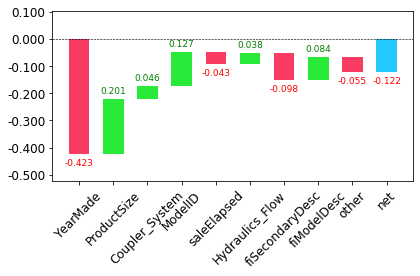

In [ ]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

This kind of information is most useful in production, rather than during model development. You can use it to provide useful information to users of your data product about the underlying reasoning behind the predictions.

这类信息在生产过程中 (而不是在模型开发过程中) 最有用。您可以使用它向数据产品的用户提供有关预测背后的基础推理的有用信息。[机器翻译]

Now that we covered some classic machine learning techniques to solve this problem, let's see how deep learning can help!

现在我们已经讨论了一些经典的机器学习技术来解决这个问题，让我们看看深度学习有什么帮助![机器翻译]

## Extrapolation and Neural Networks

# # 外推和神经网络[机器翻译]

A problem with random forests, like all machine learning or deep learning algorithms, is that they don't always generalize well to new data. We will see in which situations neural networks generalize better, but first, let's look at the extrapolation problem that random forests have.

像所有机器学习或深度学习算法一样，随机森林的一个问题是，它们并不总是能够很好地概括为新数据。我们将看到在哪些情况下神经网络概括得更好，但是首先，让我们看看随机森林的外推问题。[机器翻译]

### The Extrapolation Problem

# 外推问题[机器翻译]

In [ ]:
#hide
np.random.seed(42)

Let's consider the simple task of making predictions from 40 data points showing a slightly noisy linear relationship:

让我们考虑一下简单的任务，从40个数据点进行预测，显示出略微嘈杂的线性关系:[机器翻译]

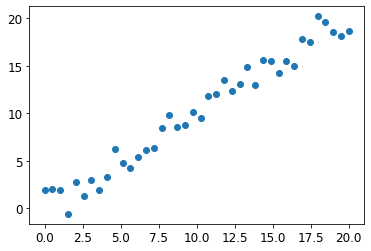

In [ ]:
x_lin = torch.linspace(0,20, steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin);

Although we only have a single independent variable, sklearn expects a matrix of independent variables, not a single vector. So we have to turn our vector into a matrix with one column. In other words, we have to change the *shape* from `[40]` to `[40,1]`. One way to do that is with the `unsqueeze` method, which adds a new unit axis to a tensor at the requested dimension:

虽然我们只有一个独立变量，但sklearn期望的是独立变量的矩阵，而不是单个向量。所以我们必须把向量变成一个有一列的矩阵。换句话说，我们必须将 * 形状 * 从 '[40]' 改为 '[40,1]'。一种方法是使用 “unsqueeze” 方法，该方法在请求的维度向张量添加一个新的单位轴:[机器翻译]

In [ ]:
xs_lin = x_lin.unsqueeze(1)
x_lin.shape,xs_lin.shape

(torch.Size([40]), torch.Size([40, 1]))

A more flexible approach is to slice an array or tensor with the special value `None`, which introduces an additional unit axis at that location:

一种更灵活的方法是用特殊值 “none” 分割数组或张量，它在该位置引入了一个额外的单位轴:[机器翻译]

In [ ]:
x_lin[:,None].shape

torch.Size([40, 1])

We can now create a random forest for this data. We'll use only the first 30 rows to train the model:

我们现在可以为此数据创建一个随机森林。我们将仅使用前30行来训练模型:[机器翻译]

In [ ]:
m_lin = RandomForestRegressor().fit(xs_lin[:30],y_lin[:30])

Then we'll test the model on the full dataset. The blue dots are the training data, and the red dots are the predictions:

然后，我们将在完整数据集上测试模型。蓝点是训练数据，红点是预测:[机器翻译]

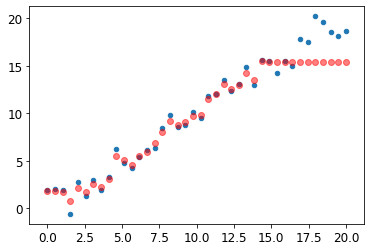

In [ ]:
plt.scatter(x_lin, y_lin, 20)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.5);

We have a big problem! Our predictions outside of the domain that our training data covered are all too low. Why do you suppose this is?


我们有一个大问题!我们在域之外的预测，即我们的训练数据覆盖都太低了。怎么你以为这是什么？[机器翻译]

Remember, a random forest just averages the predictions of a number of trees. And a tree simply predicts the average value of the rows in a leaf. Therefore, a tree and a random forest can never predict values outside of the range of the training data. This is particularly problematic for data where there is a trend over time, such as inflation, and you wish to make predictions for a future time.. Your predictions will be systematically too low.


请记住，随机森林只是对一些树木的预测进行平均。树只是预测叶子中行的平均值。因此，树和随机森林永远无法预测训练数据范围之外的值。这对于随着时间的推移出现趋势的数据尤其成问题，例如通货膨胀，并且您希望对未来时间进行预测。你的预测会系统地太低。[机器翻译]

But the problem iextends beyond time variables. Random forests are not able to extrapolate outside of the types of data they have seen, in a more general sense. That's why we need to make sure our validation set does not contain out-of-domain data.

但是这个问题超出了时间变量。从更一般的意义上来说，随机森林不能推断出它们所看到的数据类型之外。这就是为什么我们需要确保我们的验证集不包含域外数据。[机器翻译]

### Finding Out-of-Domain Data

# 查找域外数据[机器翻译]

Sometimes it is hard to know whether your test set is distributed in the same way as your training data, or, if it is different, what columns reflect that difference. There's actually an easy way to figure this out, which is to use a random forest!


有时很难知道您的测试集是否以与训练数据相同的方式分布，或者，如果不同，哪些列反映了这种差异。实际上有一个简单的方法可以解决这个问题，那就是使用随机森林![机器翻译]

But in this case we don't use the random forest to predict our actual dependent variable. Instead, we try to predict whether a row is in the validation set or the training set. To see this in action, let's combine our training and validation sets together, create a dependent variable that represents which dataset each row comes from, build a random forest using that data, and get its feature importance:

但是在这种情况下，我们不使用随机森林来预测我们的实际因变量。相反，我们尝试预测行是在验证集中还是在训练集中。为了看到这一点，让我们将训练集和验证集结合在一起，创建一个因变量来表示每行来自哪个数据集，使用该数据构建一个随机林，并获得其功能重要性:[机器翻译]

In [ ]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

cols       imp
5   saleElapsed  0.859446
9       SalesID  0.119325
13    MachineID  0.014259
0      YearMade  0.001793
8   fiModelDesc  0.001740
11    Enclosure  0.000657

This shows that there are three columns that differ significantly between the training and validation sets: `saleElapsed`, `SalesID`, and `MachineID`. It's fairly obvious why this is the case for `saleElapsed`: it's the number of days between the start of the dataset and each row, so it directly encodes the date. The difference in `SalesID` suggests that identifiers for auction sales might increment over time. `MachineID` suggests something similar might be happening for individual items sold in those auctions.


这表明训练集和验证集之间有三列显著不同: “saleelaped” 、 “salesid” 和 “machineid”。很明显，为什么 “销售延迟” 是这种情况: 它是数据集开始和每行之间的天数，所以它直接编码日期。“销售” 的差异表明，拍卖销售的标识符可能会随着时间的推移而增加。Machineid '表明，在这些拍卖中出售的单个物品可能会发生类似的情况。[机器翻译]

Let's get a baseline of the original random forest model's RMSE, then see what the effect is of removing each of these columns in turn:

让我们获取原始随机森林模型的RMSE的基线，然后看看依次删除这些列的效果:[机器翻译]

In [ ]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('SalesID','saleElapsed','MachineID'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

orig 0.232795
SalesID 0.23109
saleElapsed 0.236221
MachineID 0.233492


It looks like we should be able to remove `SalesID` and `MachineID` without losing any accuracy. Let's check:

看起来我们应该能够在不失去任何准确性的情况下移除 “salesid” 和 “machineid”。让我们检查一下:[机器翻译]

In [ ]:
time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

0.231307

Removing these variables has slightly improved the model's accuracy; but more importantly, it should make it more resilient over time, and easier to maintain and understand. We recommend that for all datasets you try building a model where your dependent variable is `is_valid`, like we did heree. It can often uncover subtle *domain shift* issues that you may otherwise miss.


移除这些变量稍微提高了模型的准确性; 但更重要的是，随着时间的推移，它应该会变得更有弹性，更容易维护和理解。我们建议，对于所有数据集，您尝试构建一个模型，其中您的因变量是 'is _ valid'，就像我们做的heree一样。它经常会发现微妙的 * 域转移 * 问题，否则你可能会错过。[机器翻译]

One thing that might help in our case is to simply avoid using old data. Often, old data shows relationships that just aren't valid any more. Let's try just using the most recent few years of the data:

在我们的案例中，有一件事可能会有所帮助，那就是简单地避免使用旧数据。通常，旧数据显示的关系不再有效。让我们尝试使用最近几年的数据:[机器翻译]

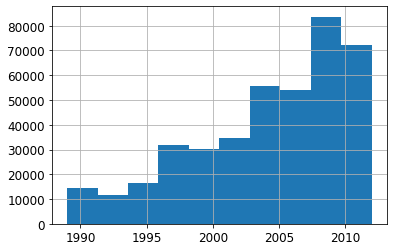

In [ ]:
xs['saleYear'].hist();

Here's the result of training on this subset:

以下是在这个子集上训练的结果:[机器翻译]

In [ ]:
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [ ]:
m = rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

(0.17768, 0.230631)

It's a tiny bit better, which shows that you shouldn't always just use your entire dataset; sometimes a subset can be better.


这稍微好一点，这表明你不应该总是只使用你的整个数据集; 有时子集会更好。[机器翻译]

Let's see if using a neural network helps.

让我们看看使用神经网络是否有帮助。[机器翻译]

### Using a Neural Network

# 使用神经网络[机器翻译]

We can use the same approach to build a neural network model. Let's first replicate the steps we took to set up the `TabularPandas` object:

我们可以用同样的方法来构建神经网络模型。让我们首先复制我们为设置 “tabularpandas” 对象所采取的步骤:[机器翻译]

In [ ]:
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

We can leverage the work we did to trim unwanted columns in the random forest by using the same set of columns for our neural network:

我们可以利用我们所做的工作来修剪随机森林中不需要的列，方法是为我们的神经网络使用相同的列集:[机器翻译]

In [ ]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

Categorical columns are handled very differently in neural networks, compared to decision tree approaches. As we saw in <<chapter_collab>>, in a neural net a great way to handle categorical variables is by using embeddings. To create embeddings, fastai needs to determine which columns should be treated as categorical variables. It does this by comparing the number of distinct levels in the variable to the value of the `max_card` parameter. If it's lower, fastai will treat the variable as categorical. Embedding sizes larger than 10,000 should generally only be used after you've tested whether there are better ways to group the variable, so we'll use 9,000 as our `max_card`:

与决策树方法相比，分类列在神经网络中的处理方式非常不同。正如我们在 <<chapter_collab>> 中看到的，在神经网络中，处理分类变量的一个很好的方法是使用嵌入。要创建嵌入，fastai需要确定哪些列应该被视为分类变量。它通过将变量中不同级别的数量与 “max_card” 参数的值进行比较来实现这一点。如果它较低，fastai将把变量视为分类。通常，只有在测试了是否有更好的方法对变量进行分组后，才应该使用大于10,000的嵌入大小，因此我们将使用9,000作为我们的 “最大卡片”:[机器翻译]

In [ ]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In this case, however, there's one variable that we absolutely do not want to treat as categorical: the `saleElapsed` variable. A categorical variable cannot, by definition, extrapolate outside the range of values that it has seen, but we want to be able to predict auction sale prices in the future. Therefore, we need to make this a continuous variable:

然而，在这种情况下，有一个变量我们绝对不想被视为分类变量: “saleelaped” 变量。根据定义，分类变量不能在它所看到的值范围之外推断，但是我们希望能够预测未来的拍卖价格。因此，我们需要使这个连续变量:[机器翻译]

In [ ]:
cont_nn.append('saleElapsed')
cat_nn.remove('saleElapsed')

Let's take a look at the cardinality of each of the categorical variables that we have chosen so far:

让我们看看到目前为止我们选择的每个分类变量的基数:[机器翻译]

In [ ]:
df_nn_final[cat_nn].nunique()

YearMade                73
ProductSize              6
Coupler_System           2
fiProductClassDesc      74
ModelID               5281
Hydraulics_Flow          3
fiSecondaryDesc        177
fiModelDesc           5059
ProductGroup             6
Enclosure                6
fiModelDescriptor      140
Drive_System             4
Hydraulics              12
Tire_Size               17
dtype: int64

The fact that there are two variables pertaining to the "model" of the equipment, both with similar very high cardinalities, suggests that they may contain similar, redundant information. Note that we would not necessarily see this when analyzing redundant features, since that relies on similar variables being sorted in the same order (that is, they need to have similarly named levels). Having a column with 5,000 levels means needing 5,000 columns in our embedding matrix, which would be nice to avoid if possible. Let's see what the impact of removing one of these model columns has on the random forest:

事实上，有两个变量与设备的 “模型” 有关，两者都具有相似的非常高的基数，这表明它们可能包含相似的冗余信息。请注意，在分析冗余特征时，我们不一定会看到这一点，因为这依赖于以相同顺序排序的类似变量 (也就是说，它们需要有类似的命名级别)。具有5,000个级别的列意味着在我们的嵌入矩阵中需要5,000列，如果可能的话，这将是很好的避免。让我们看看删除其中一个模型列对随机林的影响:[机器翻译]

In [ ]:
xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)
m2 = rf(xs_filt2, y_filt)
m_rmse(m, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)

(0.176706, 0.230642)

There's minimal impact, so we will remove it as a predictor for our neural network:

影响很小，所以我们将删除它作为我们神经网络的预测器:[机器翻译]

In [ ]:
cat_nn.remove('fiModelDescriptor')

We can create our `TabularPandas` object in the same way as when we created our random forest, with one very important addition: normalization. A random forest does not need any normalization—the tree building procedure cares only about the order of values in a variable, not at all about how they are scaled. But as we have seen, a neural network definitely does care about this. Therefore, we add the `Normalize` processor when we build our `TabularPandas` object:

我们可以创建我们的 “tabularpandas” 对象，就像我们创建我们的随机森林时一样，有一个非常重要的补充: 规范化。随机森林不需要任何规范化 -- 树构建过程只关心变量中值的顺序，而不关心它们是如何缩放的。但是正如我们所看到的，神经网络确实关心这个。因此，我们在构建 “tabularpandas” 对象时添加了 “normalize” 处理器:[机器翻译]

In [ ]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

Tabular models and data don't generally require much GPU RAM, so we can use larger batch sizes:

表格模型和数据通常不需要太多GPU RAM，因此我们可以使用更大的批处理大小:[机器翻译]

In [ ]:
dls = to_nn.dataloaders(1024)

As we've discussed, it's a good idea to set `y_range` for regression models, so let's find the min and max of our dependent variable:

正如我们已经讨论过的，为回归模型设置 “y_range” 是一个好主意，所以让我们找到因变量的最小值和最大值:[机器翻译]

In [ ]:
y = to_nn.train.y
y.min(),y.max()

(8.465899897028686, 11.863582336583399)

We can now create the `Learner` to create this tabular model. As usual, we use the application-specific learner function, to take advantage of its application-customized defaults. We set the loss function to MSE, since that's what this competition uses.


我们现在可以创建 “学习者” 来创建这个表格模型。像往常一样，我们使用特定于应用程序的learner函数，利用其应用程序自定义的默认值。我们将损失函数设置为MSE，因为这是本次比赛使用的。[机器翻译]

By default, for tabular data fastai creates a neural network with two hidden layers, with 200 and 100 activations, respectively. This works quite well for small datasets, but here we've got quite a large dataset, so we increase the layer sizes to 500 and 250:

默认情况下，对于表格数据，fastai创建具有两个隐藏层的神经网络，分别有200和100个激活。这对于小数据集非常有效，但是这里我们有一个相当大的数据集，所以我们将图层大小增加到500和250:[机器翻译]

In [ ]:
from fastai.tabular.all import *

In [ ]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

(0.005754399299621582, 0.0002754228771664202)

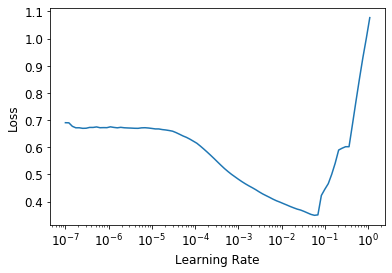

In [ ]:
learn.lr_find()

There's no need to use `fine_tune`, so we'll train with `fit_one_cycle` for a few epochs and see how it looks:

没有必要使用 “fine_tune”，所以我们将用 “fit_one_cycle” 训练几次，看看它看起来怎么样:[机器翻译]

In [ ]:
learn.fit_one_cycle(5, 1e-2)

We can use our `r_mse` function to compare the result to the random forest result we got earlier:

我们可以使用我们的 'r_mse' 函数将结果与我们之前得到的随机森林结果进行比较:[机器翻译]

In [ ]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

0.2258

It's quite a bit better than the random forest (although it took longer to train, and it's fussier about hyperparameter tuning).


它比随机森林好得多 (尽管它需要更长的时间来训练，而且它对超参数调整更加挑剔)。[机器翻译]

Before we move on, let's save our model in case we want to come back to it again later:

在我们继续之前，让我们保存我们的模型，以防以后我们想再次回到它:[机器翻译]

In [ ]:
learn.save('nn')

### Sidebar: fastai's Tabular Classes

# 侧边栏: fastai的表格类[机器翻译]

In fastai, a tabular model is simply a model that takes columns of continuous or categorical data, and predicts a category (a classification model) or a continuous value (a regression model). Categorical independent variables are passed through an embedding, and concatenated, as we saw in the neural net we used for collaborative filtering, and then continuous variables are concatenated as well.


在fastai中，表格模型只是一个简单的模型，它接受连续或分类数据的列，并预测类别 (分类模型) 或连续值 (回归模型)。分类自变量通过嵌入传递并连接，正如我们在用于协作过滤的神经网络中看到的那样，然后连续变量也连接起来。[机器翻译]

The model created in `tabular_learner` is an object of class `TabularModel`. Take a look at the source for `tabular_learner` now (remember, that's `tabular_learner??` in Jupyter). You'll see that like `collab_learner`, it first calls `get_emb_sz` to calculate appropriate embedding sizes (you can override these by using the `emb_szs` parameter, which is a dictionary containing any column names you want to set sizes for manually), and it sets a few other defaults. Other than that, it just creates the `TabularModel`, and passes that to `TabularLearner` (note that `TabularLearner` is identical to `Learner`, except for a customized `predict` method).


在 “tabular_learner” 中创建的模型是类 “tabularmodel” 的对象。现在看看 'tabular_learner' 的来源 (记住，那是Jupyter中的 'tabular_learner？')。你会看到像 'collab_learner' 一样，它首先调用 'get_emb_sz' 来计算适当的嵌入大小 (你可以通过使用 'emb_szs' 参数覆盖这些，这是一个包含要手动设置大小的任何列名的字典)，它还会设置一些其他默认值。除此之外，它只是创建了 “tabularmodel”，并将其传递给 “tabularlearner” (请注意，“tabularlearner” 与 “learner” 相同，除了自定义的 “predict” 方法)。[机器翻译]

That means that really all the work is happening in `TabularModel`, so take a look at the source for that now. With the exception of the `BatchNorm1d` and `Dropout` layers (which we'll be learning about shortly), you now have the knowledge required to understand this whole class. Take a look at the discussion of `EmbeddingNN` at the end of the last chapter. Recall that it passed `n_cont=0` to `TabularModel`. We now can see why that was: because there are zero continuous variables (in fastai the `n_` prefix means "number of," and `cont` is an abbreviation for "continuous").

这意味着所有的工作都是在 “tabularmodel” 中进行的，所以现在看看它的来源。除了 “BatchNorm1d” 和 “dropout” 层 (我们将很快了解)，您现在拥有了理解整个课程所需的知识。看看最后一章末尾对 “嵌入” 的讨论。回想一下，它将 “n_cont = 0” 传递给 “tabularmodel”。我们现在可以看到这是为什么: 因为有零个连续变量 (在fastai中，'n _' 前缀表示 “数量”，而 '连续' 是 “连续” 的缩写)。[机器翻译]

### End sidebar

# 结束侧边栏[机器翻译]

Another thing that can help with generalization is to use several models and average their predictions—a technique, as mentioned earlier, known as *ensembling*.

另一件有助于泛化的事情是使用几个模型并对它们的预测进行平均 -- 如前所述，这种技术被称为 * 集合 *。[机器翻译]

## Ensembling

# # 合奏[机器翻译]

Think back to the original reasoning behind why random forests work so well: each tree has errors, but those errors are not correlated with each other, so the average of those errors should tend towards zero once there are enough trees. Similar reasoning could be used to consider averaging the predictions of models trained using different algorithms.


回想一下为什么随机森林工作得如此好背后的原始推理: 每个树都有错误，但是这些错误彼此不相关，因此，一旦有足够多的树，这些错误的平均值应该趋向于零。类似的推理可以用来考虑对使用不同算法训练的模型的预测进行平均。[机器翻译]

In our case, we have two very different models, trained using very different algorithms: a random forest, and a neural network. It would be reasonable to expect that the kinds of errors that each one makes would be quite different. Therefore, we might expect that the average of their predictions would be better than either one's individual predictions.


在我们的例子中，我们有两个非常不同的模型，使用非常不同的算法进行训练: 随机森林和神经网络。有理由期望每个人犯的错误会大不相同。因此，我们可能会期望他们预测的平均值会比任何一个人的预测都好。[机器翻译]

As we saw earlier, a random forest is itself an ensemble. But we can then include a random forest in *another* ensemble—an ensemble of the random forest and the neural network! While ensembling won't make the difference between a successful and an unsuccessful modeling process, it can certainly add a nice little boost to any models that you have built.


正如我们之前看到的，随机森林本身就是一个整体。但是我们可以在另一个集合中包含一个随机森林 -- 随机森林和神经网络的集合!虽然合奏不会对成功和不成功的建模过程产生影响，但它肯定会给你建立的任何模型增加一点好处。[机器翻译]

One minor issue we have to be aware of is that our PyTorch model and our sklearn model create data of different types: PyTorch gives us a rank-2 tensor (i.e, a column matrix), whereas NumPy gives us a rank-1 array (a vector). `squeeze` removes any unit axes from a tensor, and `to_np` converts it into a NumPy array:

我们必须意识到的一个小问题是，我们的PyTorch模型和sklearn模型创建了不同类型的数据: PyTorch给了我们一个等级-2张量 (i.e，一个列矩阵)，而NumPy给了我们一个rank-1数组 (一个向量)。'Squeeze' 从张量中删除任何单位轴，'to_np' 将其转换为NumPy数组:[机器翻译]

In [ ]:
rf_preds = m.predict(valid_xs_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2

This gives us a better result than either model achieved on its own:

这为我们提供了比单独实现的任何一个模型更好的结果:[机器翻译]

In [ ]:
r_mse(ens_preds,valid_y)

0.22291

In fact, this result is better than any score shown on the Kaggle leaderboard. It's not directly comparable, however, because the Kaggle leaderboard uses a separate dataset that we do not have access to. Kaggle does not allow us to submit to this old competition to find out how we would done, but our results certainly look very encouraging!

事实上，这个结果比Kaggle排行榜上显示的任何分数都好。然而，这并不直接可比，因为Kaggle排行榜使用了一个我们无法访问的单独数据集。Kaggle不允许我们服从这个旧的比赛来找出我们将如何做，但是我们的结果看起来非常令人鼓舞![机器翻译]

### Boosting

# 提升[机器翻译]

So far our approach to ensembling has been to use *bagging*, which involves combining many models (each trained on a different data subset) together by averaging them. As we saw, when this is applied to decision trees, this is called a *random forest*.


到目前为止，我们的组合方法是使用 * bagging *，它涉及通过对它们进行平均来将许多模型 (每个模型在不同的数据子集上训练) 组合在一起。正如我们看到的，当这应用于决策树时，这被称为 * 随机森林 *。[机器翻译]

There is another important approach to ensembling, called *boosting*, where we add models instead of averaging them. Here is how boosting works:


还有另一种重要的组合方法，称为 * boosting *，我们添加模型而不是平均它们。以下是boosting的工作原理:[机器翻译]

- Train a small model that underfits your dataset.
- Calculate the predictions in the training set for this model.
- Subtract the predictions from the targets; these are called the "residuals" and represent the error for each point in the training set.
- Go back to step 1, but instead of using the original targets, use the residuals as the targets for the training.
- Continue doing this until you reach some stopping criterion, such as a maximum number of trees, or you observe your validation set error getting worse.


-训练一个不适合您的数据集的小模型。
-计算此模型的训练集中的预测。
-从目标中减去预测; 这些称为 “残差”，表示训练集中每个点的误差。
-返回步骤1，但不要使用原始目标，而是使用残差作为训练目标。
-继续这样做，直到你达到一些停止标准，比如最大数量的树，或者你观察到你的验证集错误变得更糟。[机器翻译]

Using this approach, each new tree will be attempting to fit the error of all of the previous trees combined. Because we are continually creating new residuals, by subtracting the predictions of each new tree from the residuals from the previous tree, the residuals will get smaller and smaller.


使用这种方法，每个新树将试图适应所有以前的树组合的错误。因为我们不断创建新的残差，所以通过从上一个树的残差中减去每个新树的预测，残差将变得越来越小。[机器翻译]

To make predictions with an ensemble of boosted trees, we calculate the predictions from each tree, and then add them all together. There are many models following this basic approach, and many names for the same models. *Gradient boosting machines* (GBMs) and *gradient boosted decision trees* (GBDTs) are the terms you're most likely to come across, or you may see the names of specific libraries implementing these; at the time of writing, *XGBoost* is the most popular.


为了用增强树的集合进行预测，我们计算每棵树的预测，然后将它们加在一起。有许多模型遵循这种基本方法，并且有许多相同模型的名称。* 梯度提升机器 * (GBMs) 和 * 梯度提升决策树 * (GBDTs) 是您最有可能遇到的术语，或者您可能会看到实现这些的特定库的名称; 在撰写本文时，* XGBoost * 是最受欢迎的。[机器翻译]

Note that, unlike with random forests, with this approach there is nothing to stop us from overfitting. Using more trees in a random forest does not lead to overfitting, because each tree is independent of the others. But in a boosted ensemble, the more trees you have, the better the training error becomes, and eventually you will see overfitting on the validation set.


请注意，与随机森林不同，使用这种方法没有什么可以阻止我们过度拟合。在随机森林中使用更多的树不会导致过度拟合，因为每棵树都独立于其他树。但是在一个提升的合奏中，你拥有的树越多，训练错误就越好，最终你会在验证集上看到过度拟合。[机器翻译]

We are not going to go into detail on how to train a gradient boosted tree ensemble here, because the field is moving rapidly, and any guidance we give will almost certainly be outdated by the time you read this. As we write this, sklearn has just added a `HistGradientBoostingRegressor` class that provides excellent performance. There are many hyperparameters to tweak for this class, and for all gradient boosted tree methods we have seen. Unlike random forests, gradient boosted trees are extremely sensitive to the choices of these hyperparameters; in practice, most people use a loop that tries a range of different hyperparameters to find the ones that work best.

我们不打算详细讨论如何在这里训练梯度提升树集合，因为这个领域正在快速移动，当你读到这篇文章时，我们给出的任何指导几乎肯定会过时。在我们写这篇文章的时候，sklearn刚刚添加了一个 “histgradientboostingregressore” 类，它提供了出色的性能。对于这个类，有许多超参数需要调整，对于我们已经看到的所有渐变提升树方法。与随机森林不同，渐变增强树对这些超参数的选择非常敏感; 实际上，大多数人使用一个循环，尝试一系列不同的超参数来找到最有效的超参数。[机器翻译]

One more technique that has gotten great results is to use embeddings learned by a neural net in a machine learning model.

另一种获得巨大结果的技术是在机器学习模型中使用神经网络学习的嵌入。[机器翻译]

### Combining Embeddings with Other Methods

# 结合嵌入和其他方法[机器翻译]

The abstract of the entity embedding paper we mentioned at the start of this chapter states: "the embeddings obtained from the trained neural network boost the performance of all tested machine learning methods considerably when used as the input features instead". It includes the very interesting table in <<embedding_mixed>>.

我们在本章开头提到的实体嵌入论文的摘要指出: “当用作输入特征时，从训练好的神经网络获得的嵌入大大提高了所有测试机器学习方法的性能”。它包括 <<embedding_mixed>> 中非常有趣的表。[机器翻译]

<img alt="Embeddings combined with other methods" width="500" id="embedding_mixed" caption="Effects of using neural network embeddings as input to other machine learning methods (courtesy of Cheng Guo and Felix Berkhahn)" src="images/att_00054.png">

<Img alt = "嵌入与其他方法结合" width = "500" id = "嵌入 _ 混合" caption = "使用神经网络嵌入作为其他机器学习方法输入的效果 (由程果和费利克斯 · 伯克哈恩)" src = "images/att_00054.png">[机器翻译]

This is showing the mean average percent error (MAPE) compared among four different modeling techniques, three of which we have already seen, along with *k*-nearest neighbors (KNN), which is a very simple baseline method. The first numeric column contains the results of using the methods on the data provided in the competition; the second column shows what happens if you first train a neural network with categorical embeddings, and then use those categorical embeddings instead of the raw categorical columns in the model. As you see, in every case, the models are dramatically improved by using the embeddings instead of the raw categories.


这显示了四种不同建模技术之间的平均百分比误差 (MAPE)，其中三种我们已经看到，以及 * k *-最近邻居 (KNN)，这是一个非常简单的基线方法。第一个数字列包含在比赛中提供的数据上使用方法的结果; 第二列显示如果您首先使用分类嵌入训练神经网络会发生什么，然后使用这些分类嵌入，而不是模型中的原始分类列。如您所见，在每种情况下，通过使用嵌入而不是原始类别，模型都得到显著改进。[机器翻译]

This is a really important result, because it shows that you can get much of the performance improvement of a neural network without actually having to use a neural network at inference time. You could just use an embedding, which is literally just an array lookup, along with a small decision tree ensemble.


这是一个非常重要的结果，因为它表明你可以获得神经网络的大部分性能改进，而不必在推理时实际使用神经网络。你可以只使用一个嵌入，这实际上只是一个数组查找，以及一个小的决策树集合。[机器翻译]

These embeddings need not even be necessarily learned separately for each model or task in an organization. Instead, once a set of embeddings are learned for some column for some task, they could be stored in a central place, and reused across multiple models. In fact, we know from private communication with other practitioners at large companies that this is already happening in many places.

对于组织中的每个模型或任务，这些嵌入甚至不需要单独学习。相反，一旦为某些任务的某个列学习了一组嵌入，它们就可以存储在中心位置，并在多个模型中重复使用。事实上，我们从与大公司其他从业者的私人交流中了解到，这种情况已经在许多地方发生。[机器翻译]

## Conclusion: Our Advice for Tabular Modeling

# # 结论: 我们对表格建模的建议[机器翻译]

We have dicussed two approaches to tabular modeling: decision tree ensembles and neural networks. We've also mentioned two different decision tree ensembles: random forests, and gradient boosting machines. Each is very effective, but each also has compromises:


我们讨论了两种表格建模的方法: 决策树集合和神经网络。我们还提到了两种不同的决策树集合: 随机森林和梯度提升机器。每一个都非常有效，但每一个都有妥协:[机器翻译]

- *Random forests* are the easiest to train, because they are extremely resilient to hyperparameter choices and require very little preprocessing. They are very fast to train, and should not overfit if you have enough trees. But they can be a little less accurate, especially if extrapolation is required, such as predicting future time periods.


-* 随机森林 * 是最容易训练的，因为它们对超参数选择具有极大的弹性，并且需要非常少的预处理。它们训练非常快，如果你有足够的树，就不应该过度健康。但是它们可能不太准确，特别是如果需要外推，比如预测未来的时间段。[机器翻译]

- *Gradient boosting machines* in theory are just as fast to train as random forests, but in practice you will have to try lots of different hyperparameters. They can overfit, but they are often a little more accurate than random forests.


-* 梯度助推机 * 理论上与随机森林一样快速训练，但实际上你必须尝试许多不同的超参数。它们可能会过度匹配，但通常比随机森林更精确一点。[机器翻译]

- *Neural networks* take the longest time to train, and require extra preprocessing, such as normalization; this normalization needs to be used at inference time as well. They can provide great results and extrapolate well, but only if you are careful with your hyperparameters and take care to avoid overfitting.


-* 神经网络 * 需要训练的时间最长，并且需要额外的预处理，例如归一化; 这种归一化也需要在推理时使用。它们可以提供很好的结果并很好地推断，但前提是你要小心你的超参数并注意避免过度拟合。[机器翻译]

We suggest starting your analysis with a random forest. This will give you a strong baseline, and you can be confident that it's a reasonable starting point. You can then use that model for feature selection and partial dependence analysis, to get a better understanding of your data.


我们建议从一个随机森林开始你的分析。这会给你一个强有力的基线，你可以确信这是一个合理的起点。然后，您可以使用该模型进行特征选择和部分相关性分析，以更好地了解您的数据。[机器翻译]

From that foundation, you can try neural nets and GBMs, and if they give you significantly better results on your validation set in a reasonable amount of time, you can use them. If decision tree ensembles are working well for you, try adding the embeddings for the categorical variables to the data, and see if that helps your decision trees learn better.

从这个基础上，你可以尝试神经网络和GBMs，如果它们在合理的时间内给你的验证集带来更好的结果，你可以使用它们。如果决策树集合对您很有用，请尝试将分类变量的嵌入添加到数据中，看看这是否有助于您的决策树更好地学习。[机器翻译]

## Questionnaire

# # 问卷调查[机器翻译]

1. What is a continuous variable?
1. What is a categorical variable?
1. Provide two of the words that are used for the possible values of a categorical variable.
1. What is a "dense layer"?
1. How do entity embeddings reduce memory usage and speed up neural networks?
1. What kinds of datasets are entity embeddings especially useful for?
1. What are the two main families of machine learning algorithms?
1. Why do some categorical columns need a special ordering in their classes? How do you do this in Pandas?
1. Summarize what a decision tree algorithm does.
1. Why is a date different from a regular categorical or continuous variable, and how can you preprocess it to allow it to be used in a model?
1. Should you pick a random validation set in the bulldozer competition? If no, what kind of validation set should you pick?
1. What is pickle and what is it useful for?
1. How are `mse`, `samples`, and `values` calculated in the decision tree drawn in this chapter?
1. How do we deal with outliers, before building a decision tree?
1. How do we handle categorical variables in a decision tree?
1. What is bagging?
1. What is the difference between `max_samples` and `max_features` when creating a random forest?
1. If you increase `n_estimators` to a very high value, can that lead to overfitting? Why or why not?
1. In the section "Creating a Random Forest", just after <<max_features>>, why did `preds.mean(0)` give the same result as our random forest?
1. What is "out-of-bag-error"?
1. Make a list of reasons why a model's validation set error might be worse than the OOB error. How could you test your hypotheses?
1. Explain why random forests are well suited to answering each of the following question:
   - How confident are we in our predictions using a particular row of data?
   - For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
   - Which columns are the strongest predictors?
   - How do predictions vary as we vary these columns?
1. What's the purpose of removing unimportant variables?
1. What's a good type of plot for showing tree interpreter results?
1. What is the "extrapolation problem"?
1. How can you tell if your test or validation set is distributed in a different way than your training set?
1. Why do we make `saleElapsed` a continuous variable, even although it has less than 9,000 distinct values?
1. What is "boosting"?
1. How could we use embeddings with a random forest? Would we expect this to help?
1. Why might we not always use a neural net for tabular modeling?

1.什么是连续变量？
1.什么是分类变量？
1.提供两个用于分类变量可能值的单词。
1.什么是 “致密层”？
1.实体嵌入如何减少内存使用并加速神经网络？
1.实体嵌入对哪些类型的数据集特别有用？
1.机器学习算法的两个主要家族是什么？
1.为什么有些分类列需要在类中进行特殊排序？你如何在熊猫中做到这一点？
1.总结一个决策树算法是做什么的。
1.为什么一个日期不同于常规的分类变量或连续变量，你如何预处理它以允许它在模型中使用？
1.你应该在推土机比赛中选择随机验证集吗？如果没有，您应该选择哪种验证集？
1.什么是泡菜，它有什么用？
1.本章绘制的决策树中 'mse' 、 'samples' 和 'values' 是如何计算的？
1.在构建决策树之前，我们如何处理异常值？
1.我们如何处理决策树中的分类变量？
1.什么是bagging？
1.创建随机森林时，'max_samples' 和 'max_features' 有什么区别？
1.如果将 “n_estimators” 增加到一个非常高的值，会导致过度拟合吗？为什么或为什么不？
1.在 “创建随机森林” 一节中，刚刚在 <<max_features>> 之后，为什么 'preds.mean(0)' 给出的结果与我们的随机森林相同？
1.什么是 “出袋错误”？
1.列出模型的验证集错误可能比OOB错误更糟糕的原因。你怎么能测试你的假设？
1.解释为什么随机森林非常适合回答以下每个问题:
-我们对使用特定一行数据的预测有多大信心？
-对于使用特定数据行进行预测，最重要的因素是什么，它们如何影响预测？
-哪些列是最强的预测？
-随着我们改变这些列，预测如何变化？
1.去掉不重要的变量的目的是什么？
1.什么是显示树解释器结果的好类型的图？
1.什么是 “外推问题”？
1。你如何判断你的测试或验证集是否以不同于训练集的方式分发？
1.为什么我们让 “saleelaped” 成为一个连续变量，即使它的不同值少于9,000？
1.什么是 “助推”？
1.我们如何使用随机森林的嵌入？我们希望这能有所帮助吗？
1.为什么我们不总是使用神经网络进行表格建模？[机器翻译]

### Further Research

# 进一步研究[机器翻译]

1. Pick a competition on Kaggle with tabular data (current or past) and try to adapt the techniques seen in this chapter to get the best possible results. Compare your results to the private leaderboard.
1. Implement the decision tree algorithm in this chapter from scratch yourself, and try it on the datase you used in the first exercise.
1. Use the embeddings from the neural net in this chapter in a random forest, and see if you can improve on the random forest results we saw.
1. Explain what each line of the source of `TabularModel` does (with the exception of the `BatchNorm1d` and `Dropout` layers).

1.用表格数据 (当前或过去) 在Kaggle上挑选一个竞争对手，并尝试调整本章中看到的技术以获得最佳结果。将您的结果与私人排行榜进行比较。
1.自己从头开始实现本章中的决策树算法，并在你在第一个练习中使用的datase上尝试一下。
1.在随机森林中使用本章中神经网络的嵌入，看看您是否可以改进我们看到的随机森林结果。
1.解释 'tabularmodel' 的来源的每一行做什么 (除了 'BatchNorm1d' 和 'dropout' 层)。[机器翻译]